# Get Kaggle Data set 

In [1]:
'''import kagglehub

# Download latest version
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")

print("Path to dataset files:", path)'''

'import kagglehub\n\n# Download latest version\npath = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")\n\nprint("Path to dataset files:", path)'

# Import necessary libraries


In [78]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import random
import pandas as pd
import csv
from tqdm.notebook import tqdm
import time
import seaborn as sns


# Load and filter dataset

In [66]:
num_images = 750
# Try to load styles.csv with appropriate quoting
try:
    # Use more compatible parameters for reading problematic CSV
    styles_df = pd.read_csv('fashion-dataset/styles.csv', 
                           quoting=csv.QUOTE_NONE, 
                           on_bad_lines='skip',
                           escapechar='\\')
    print(f"Loaded styles.csv with {len(styles_df)} entries")
    
    # Check if expected columns exist
    if 'gender' in styles_df.columns and 'masterCategory' in styles_df.columns:
        # Filter for men's topwear
        men_topwear = styles_df[(styles_df['gender'] == 'Men') & 
                              (styles_df['masterCategory'] == 'Accessories')]
        
        print(f"Found {len(men_topwear)} Men's Accessories")
        
        # Get the IDs of men's topwear items
        men_topwear_ids = men_topwear['id'].astype(str).tolist()
    else:
        print("Required columns not found in styles.csv")
        men_topwear_ids = ['1163', '1164', '1165']  # Fall back to example IDs
        
except Exception as e:
    print(f"Error loading styles.csv: {e}")
    print("Using JSON examples instead")
    # Extract IDs from JSON examples (these are men's t-shirts based on the JSON content)
    men_topwear_ids = ['1163', '1164', '1165']
    print(f"Using {len(men_topwear_ids)} IDs from JSON examples")

# Set path to the dataset
dataset_path = "fashion-dataset/images"

# Get all available image files in the dataset
all_image_files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]
print(f"Total number of images in dataset: {len(all_image_files)}")

# Try to find images matching the men's topwear IDs
topwear_images = []
for img_file in all_image_files:
    # Extract numeric part of filename as ID
    id_part = os.path.splitext(img_file)[0]  # Remove extension
    if id_part in men_topwear_ids:
        topwear_images.append(img_file)

if len(topwear_images) > 0:
    print(f"Found {len(topwear_images)} exact matches for men's topwear")
    selected_files = topwear_images
else:
    print("No exact matches found. Checking for partial matches...")
    
    # Try partial matching on filename
    topwear_images = []
    for img_file in all_image_files:
        file_id = os.path.splitext(img_file)[0]
        for id_value in men_topwear_ids:
            if id_value in file_id:
                topwear_images.append(img_file)
                break

    if len(topwear_images) > 0:
        print(f"Found {len(topwear_images)} partial matches for men's topwear")
        selected_files = topwear_images
    else:
        print("No matches found. Using random subset of all images.")
        # If no matches, use a random subset
        np.random.seed(42)  # For reproducibility
        num_samples = min(500, len(all_image_files))
        selected_files = np.random.choice(all_image_files, size=num_samples, replace=False)

# If too many matches, take a subset
if len(selected_files) > num_images:
    np.random.seed(42)  # For reproducibility
    selected_files = np.random.choice(selected_files, size=num_images, replace=False)

print(f"Selected {len(selected_files)} images for processing")

Loaded styles.csv with 44427 entries
Found 4413 Men's Accessories
Total number of images in dataset: 44441
Found 4413 exact matches for men's topwear
Selected 750 images for processing


# Preview selected images

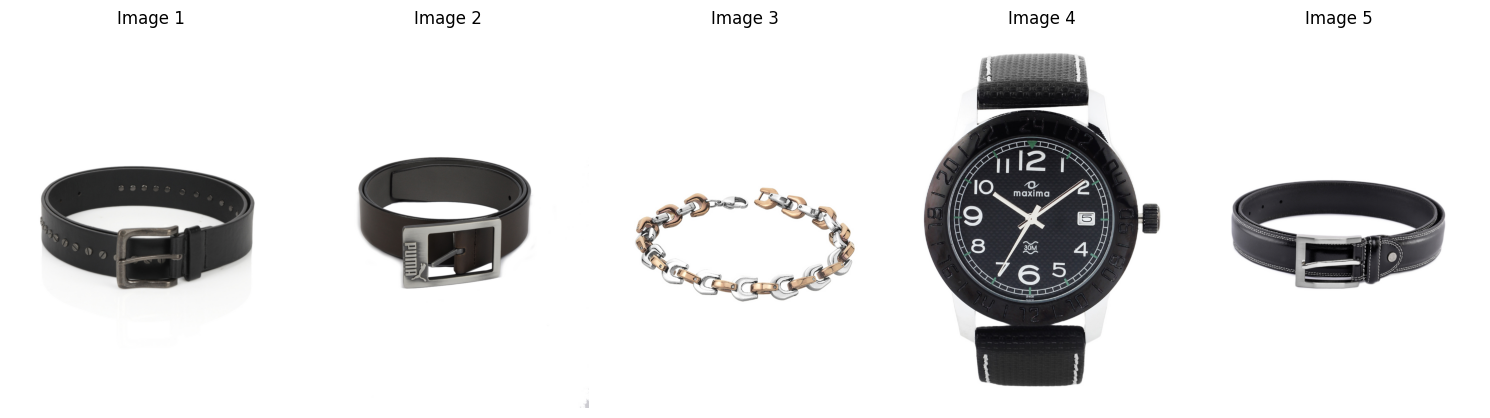

In [67]:
plt.figure(figsize=(15, 10))
for i in range(min(5, len(selected_files))):
    img_path = os.path.join(dataset_path, selected_files[i])
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')
plt.tight_layout()
plt.show()

# Enhanced feature extraction with background removal, color, shape, and focus on foreground objects

Extracting features with color, shape and background removal:   0%|          | 0/750 [00:00<?, ?it/s]

Successfully processed 743 images


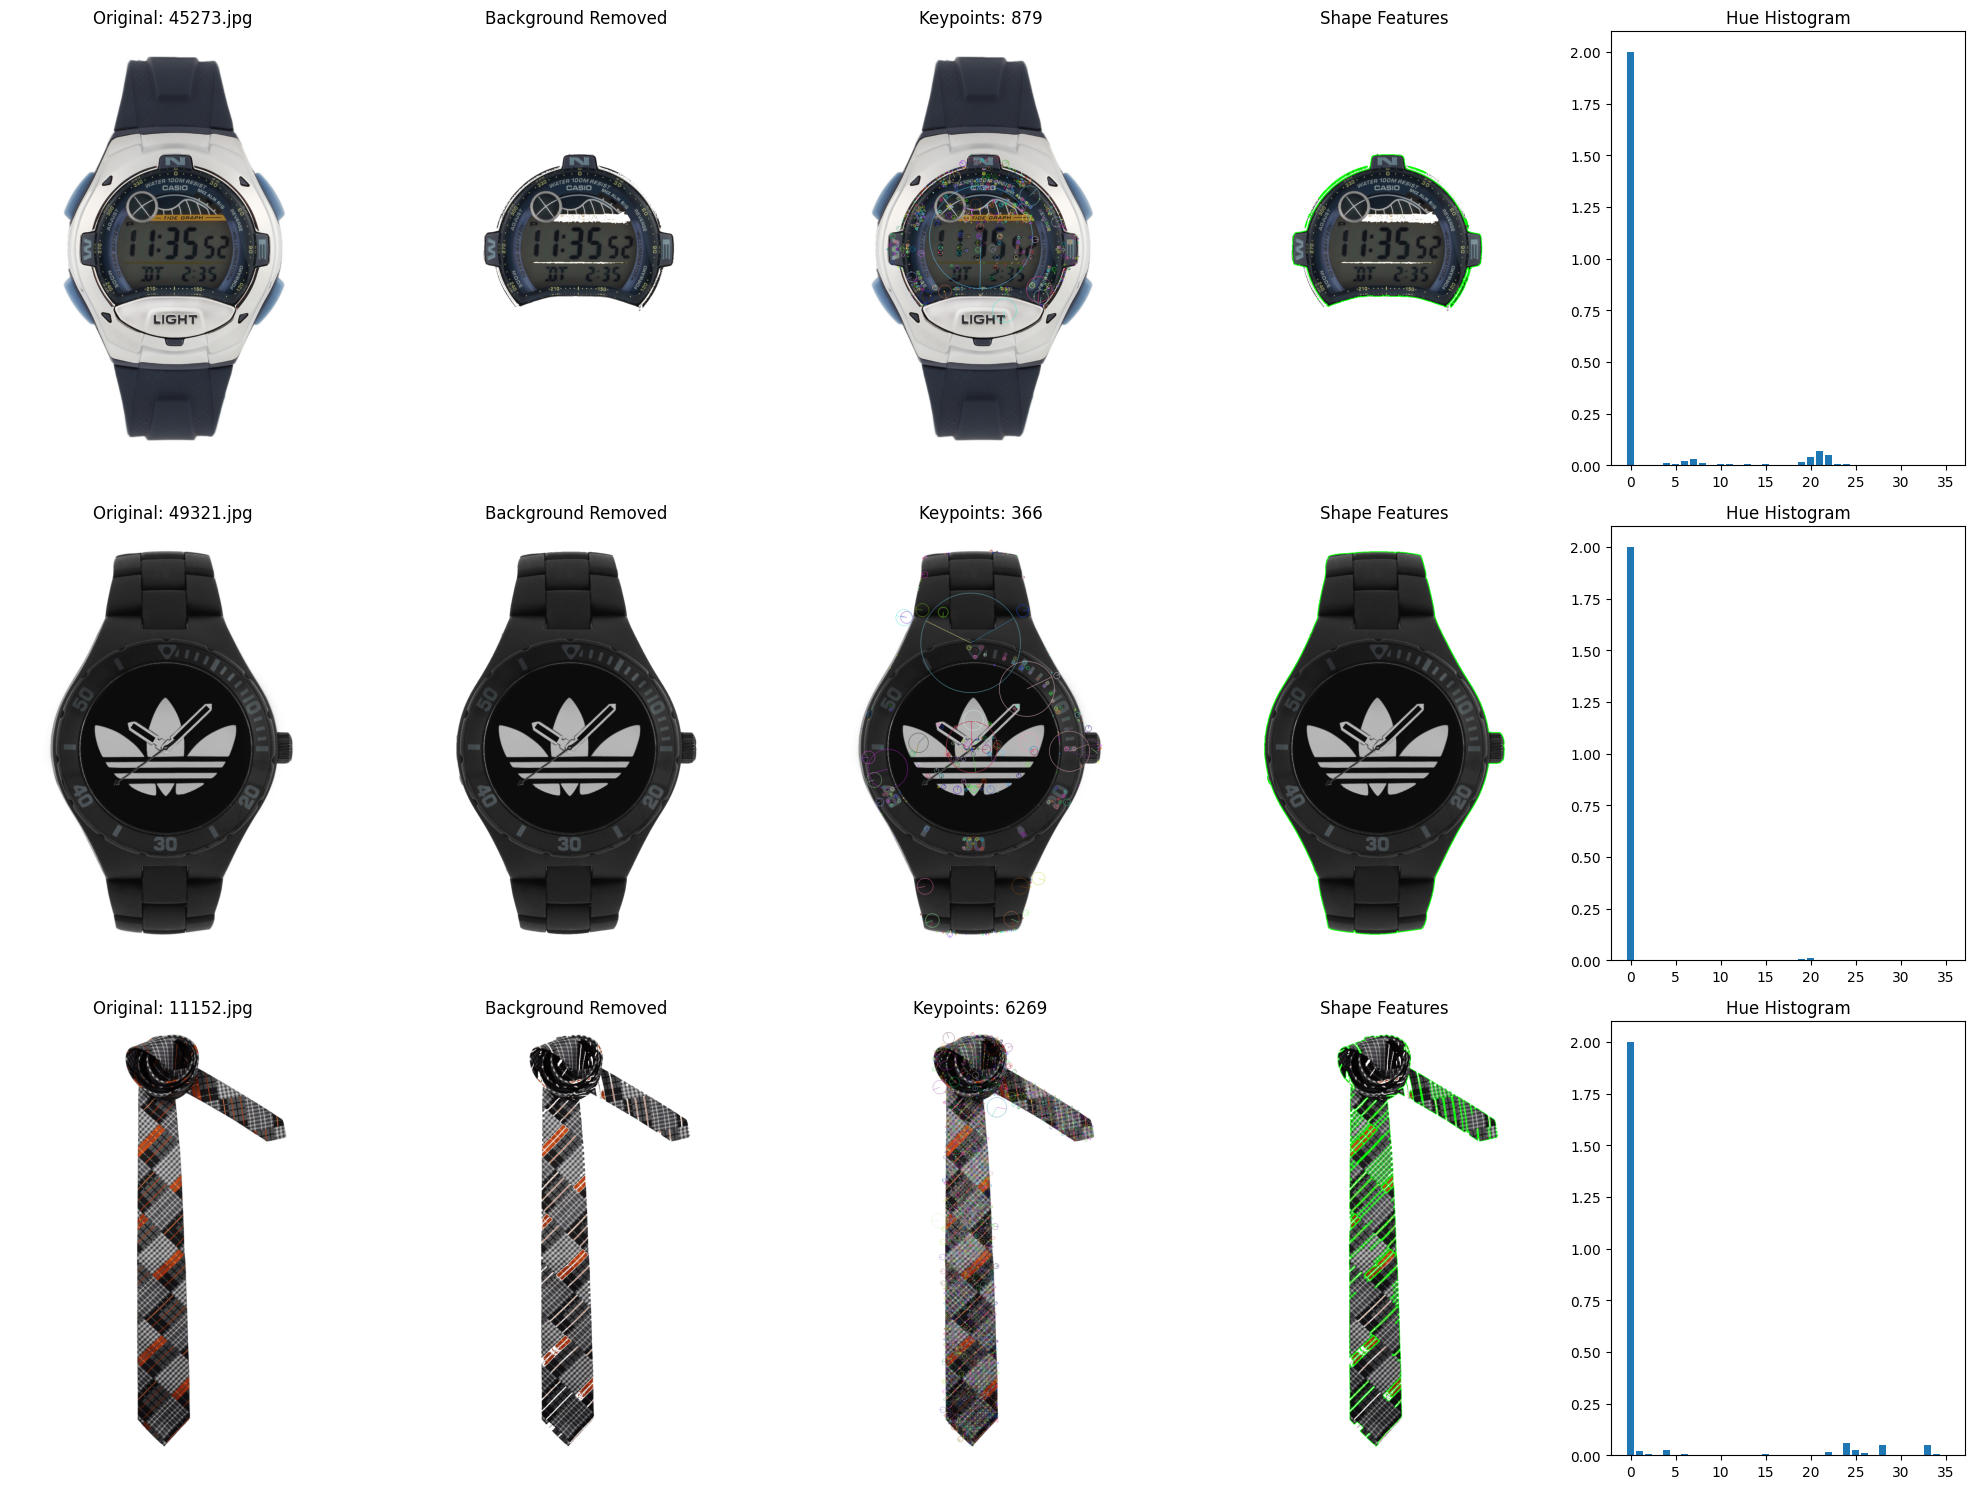

In [ ]:

def preprocess_and_extract_features(image_path):
    """Extract SIFT features with improved background and skin removal"""
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        return None, None, None
    
    # Convert to RGB for processing
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 1. IMPROVED BACKGROUND REMOVAL
    # Convert to grayscale for thresholding
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use Otsu's thresholding to automatically find the optimal threshold value
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Find the largest contour (assuming it's the main object)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        # Create a mask with only the largest contour
        object_mask = np.zeros_like(mask)
        cv2.drawContours(object_mask, [largest_contour], 0, 255, -1)
        
        # 2. SKIN DETECTION AND REMOVAL
        # Convert to YCrCb color space (better for skin detection)
        imageYCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        min_YCrCb = np.array([0, 133, 77], np.uint8)
        max_YCrCb = np.array([235, 173, 127], np.uint8)
        
        # Detect skin regions
        skinRegion = cv2.inRange(imageYCrCb, min_YCrCb, max_YCrCb)
        
        # Create inverted mask for non-skin regions - reduce skin influence
        non_skin_mask = cv2.bitwise_not(skinRegion)
        
        # Combine with object mask - prioritize product over skin
        object_mask = cv2.bitwise_and(object_mask, non_skin_mask)
        
        # Apply the mask to isolate the object
        foreground = cv2.bitwise_and(img, img, mask=object_mask)
        
        # Set background to white
        background = np.ones_like(img) * 255
        background_mask = cv2.bitwise_not(object_mask)
        background = cv2.bitwise_and(background, background, mask=background_mask)
        
        # Combine foreground and white background
        processed_img = cv2.add(foreground, background)
    else:
        # If no contours found, use the original image
        processed_img = img
    
    # 3. FEATURE EXTRACTION
    # Convert processed image to grayscale
    processed_gray = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
    
    # Apply bilateral filter for edge-preserving smoothing
    filtered = cv2.bilateralFilter(processed_gray, 9, 75, 75)
    
    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(filtered, None)
    
    return keypoints, descriptors, processed_img

def extract_shape_features(img):
    # Convert to grayscale if the image has multiple channels
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    
    # Apply threshold to get binary image
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours on the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If no contours found, return default values
    if not contours:
        return {
            'aspect_ratio': 0, 'extent': 0, 'solidity': 0, 
            'equivalent_diameter': 0, 'convexity': 0
        }
    
    # Get the largest contour by area
    main_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(main_contour)
    
    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(main_contour)
    aspect_ratio = float(w) / h if h > 0 else 0
    
    # Get rotated rectangle
    rect = cv2.minAreaRect(main_contour)
    box = cv2.boxPoints(rect)
    box = np.int_(box)  # Using np.int_ instead of np.int0
    rect_area = cv2.contourArea(box)
    extent = float(area) / rect_area if rect_area > 0 else 0
    
    # Get convex hull
    hull = cv2.convexHull(main_contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area > 0 else 0
    
    # Calculate equivalent diameter
    equivalent_diameter = np.sqrt(4 * area / np.pi) if area > 0 else 0
    
    # Calculate convexity
    hull_perimeter = cv2.arcLength(hull, True)
    contour_perimeter = cv2.arcLength(main_contour, True)
    convexity = hull_perimeter / contour_perimeter if contour_perimeter > 0 else 0
    
    return {
        'aspect_ratio': aspect_ratio,
        'extent': extent,
        'solidity': solidity,
        'equivalent_diameter': equivalent_diameter,
        'convexity': convexity
    }

def extract_color_features(img):
    """Extract enhanced color features from an image"""
    # Convert to HSV color space (better for color analysis)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Split into channels
    h, s, v = cv2.split(hsv_img)
    
    # Create color histograms with more bins for better discrimination
    h_bins = 36  # Increased from 30
    s_bins = 32
    v_bins = 32
    
    h_hist = cv2.calcHist([h], [0], None, [h_bins], [0, 180])
    s_hist = cv2.calcHist([s], [0], None, [s_bins], [0, 256])
    v_hist = cv2.calcHist([v], [0], None, [v_bins], [0, 256])
    
    # Normalize histograms
    h_hist = cv2.normalize(h_hist, h_hist, 0, 1, cv2.NORM_MINMAX)
    s_hist = cv2.normalize(s_hist, s_hist, 0, 1, cv2.NORM_MINMAX)
    v_hist = cv2.normalize(v_hist, v_hist, 0, 1, cv2.NORM_MINMAX)
    
    # Get dominant colors using K-means
    pixels = hsv_img.reshape(-1, 3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    k = 8  # Increased from 5 for more color detail
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Count pixels in each cluster
    counts = np.bincount(labels.flatten())
    
    # Sort clusters by count (largest first)
    sorted_indices = np.argsort(counts)[::-1]
    sorted_centers = centers[sorted_indices]
    sorted_counts = counts[sorted_indices]
    
    # Normalize counts to get percentage
    percentages = sorted_counts / np.sum(sorted_counts)
    
    # Combine centers with percentages for weighted features
    dominant_colors = []
    for i in range(len(sorted_centers)):
        dominant_colors.extend(sorted_centers[i] * percentages[i])
    
    # Add spatial color information
    spatial_features = extract_spatial_features(img)
    
    # Combine all color features
    color_features = np.concatenate([
        h_hist.flatten() * 2.0,  # Weight hue higher
        s_hist.flatten() * 1.5,  # Weight saturation higher
        v_hist.flatten(),
        np.array(dominant_colors),
        spatial_features
    ])
    
    return color_features

def extract_spatial_features(img, grid_size=4):
    """Extract spatial layout features (color/texture by region)"""
    h, w = img.shape[:2]
    cell_h, cell_w = h // grid_size, w // grid_size
    
    # For each grid cell, compute color and texture features
    spatial_features = []
    
    for i in range(grid_size):
        for j in range(grid_size):
            # Extract cell
            cell = img[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
            
            # Compute mean color in HSV
            cell_hsv = cv2.cvtColor(cell, cv2.COLOR_BGR2HSV)
            mean_hsv = np.mean(cell_hsv, axis=(0,1))
            
            # Simple texture measure (standard deviation)
            std_hsv = np.std(cell_hsv, axis=(0,1))
            
            # Add position information
            position = [i/grid_size, j/grid_size]
            
            # Combine features
            cell_features = np.concatenate([mean_hsv, std_hsv, position])
            spatial_features.append(cell_features)
    
    return np.concatenate(spatial_features)

def extract_texture_features(image_path, processed_img=None):
    """Extract HOG and edge-based texture features focusing on the object"""
    # Use processed image if provided, otherwise process the image
    if processed_img is not None:
        img = processed_img
    else:
        img = cv2.imread(image_path)
        if img is None:
            return None
    
    # Resize for consistency
    img = cv2.resize(img, (128, 128))
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Create edge image using Canny
    edges = cv2.Canny(gray, 50, 150)
    
    # Enhance edges
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    
    # Calculate HOG features on both grayscale and edge images
    cell_size = (8, 8)
    block_size = (2, 2)
    nbins = 9
    
    # Calculate gradients on grayscale
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1)
    
    # Calculate gradient magnitude and orientation
    magnitude, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    
    # Quantize orientations into bins
    angle_bins = np.int32(angle / (180 / nbins)) % nbins
    
    # Create HOG descriptor for grayscale
    hog_features = np.zeros((gray.shape[0] // cell_size[0], gray.shape[1] // cell_size[1], nbins))
    
    # Accumulate gradients into orientation bins
    for i in range(gray.shape[0] // cell_size[0]):
        for j in range(gray.shape[1] // cell_size[1]):
            for k in range(nbins):
                cell_mask = (angle_bins[i*cell_size[0]:(i+1)*cell_size[0], 
                                      j*cell_size[1]:(j+1)*cell_size[1]] == k)
                hog_features[i, j, k] = np.sum(magnitude[i*cell_size[0]:(i+1)*cell_size[0], 
                                                      j*cell_size[1]:(j+1)*cell_size[1]][cell_mask])
    
    # Flatten HOG features
    hog_features_flat = hog_features.flatten()
    
    return hog_features_flat

# Process all selected images
feature_data = {}
for img_file in tqdm(selected_files, desc="Extracting features with color, shape and background removal"):
    img_path = os.path.join(dataset_path, img_file)
    keypoints, descriptors, processed_img = preprocess_and_extract_features(img_path)
    
    if keypoints is not None and len(keypoints) > 0 and processed_img is not None:
        # Store SIFT features
        feature_data[img_file] = {
            'keypoints': keypoints,
            'descriptors': descriptors,
            'processed_img': processed_img
        }
        
        # Extract texture features
        texture_features = extract_texture_features(img_path, processed_img)
        if texture_features is not None:
            feature_data[img_file]['texture_features'] = texture_features
        
        # Extract color features
        color_features = extract_color_features(processed_img)
        feature_data[img_file]['color_features'] = color_features
        
        # Extract shape features for accessories
        shape_features = extract_shape_features(processed_img)
        feature_data[img_file]['shape_features'] = shape_features

print(f"Successfully processed {len(feature_data)} images")

# Visualize original vs processed images and feature extraction
if len(feature_data) > 0:
    sample_size = min(3, len(feature_data))
    sample_files = random.sample(list(feature_data.keys()), sample_size)
    
    plt.figure(figsize=(20, 5*sample_size))
    for i, img_file in enumerate(sample_files):
        # Original image
        img_path = os.path.join(dataset_path, img_file)
        orig_img = cv2.imread(img_path)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        
        # Processed image
        proc_img = feature_data[img_file]['processed_img']
        proc_img = cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB)
        
        # Convert to HSV for visualization
        hsv_img = cv2.cvtColor(proc_img, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv_img)
        
        # Original with keypoints
        kp_img = cv2.drawKeypoints(orig_img.copy(), feature_data[img_file]['keypoints'], None,
                                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
        # Visualization of shape features - show contours
        shape_viz = proc_img.copy()
        gray = cv2.cvtColor(shape_viz, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(shape_viz, contours, -1, (0, 255, 0), 2)
        
        # Display
        plt.subplot(sample_size, 5, 5*i + 1)
        plt.imshow(orig_img)
        plt.title(f"Original: {img_file}")
        plt.axis('off')
        
        plt.subplot(sample_size, 5, 5*i + 2)
        plt.imshow(proc_img)
        plt.title("Background Removed")
        plt.axis('off')
        
        plt.subplot(sample_size, 5, 5*i + 3)
        plt.imshow(kp_img)
        plt.title(f"Keypoints: {len(feature_data[img_file]['keypoints'])}")
        plt.axis('off')
        
        plt.subplot(sample_size, 5, 5*i + 4)
        plt.imshow(shape_viz)
        plt.title("Shape Features")
        plt.axis('off')
        
        # Show color histogram
        plt.subplot(sample_size, 5, 5*i + 5)
        color_hist = feature_data[img_file]['color_features'][:36]  # Hue histogram
        plt.bar(range(len(color_hist)), color_hist)
        plt.title("Hue Histogram")
    
    plt.tight_layout()
    plt.show()

# Enhanced visualization of all preprocessing steps

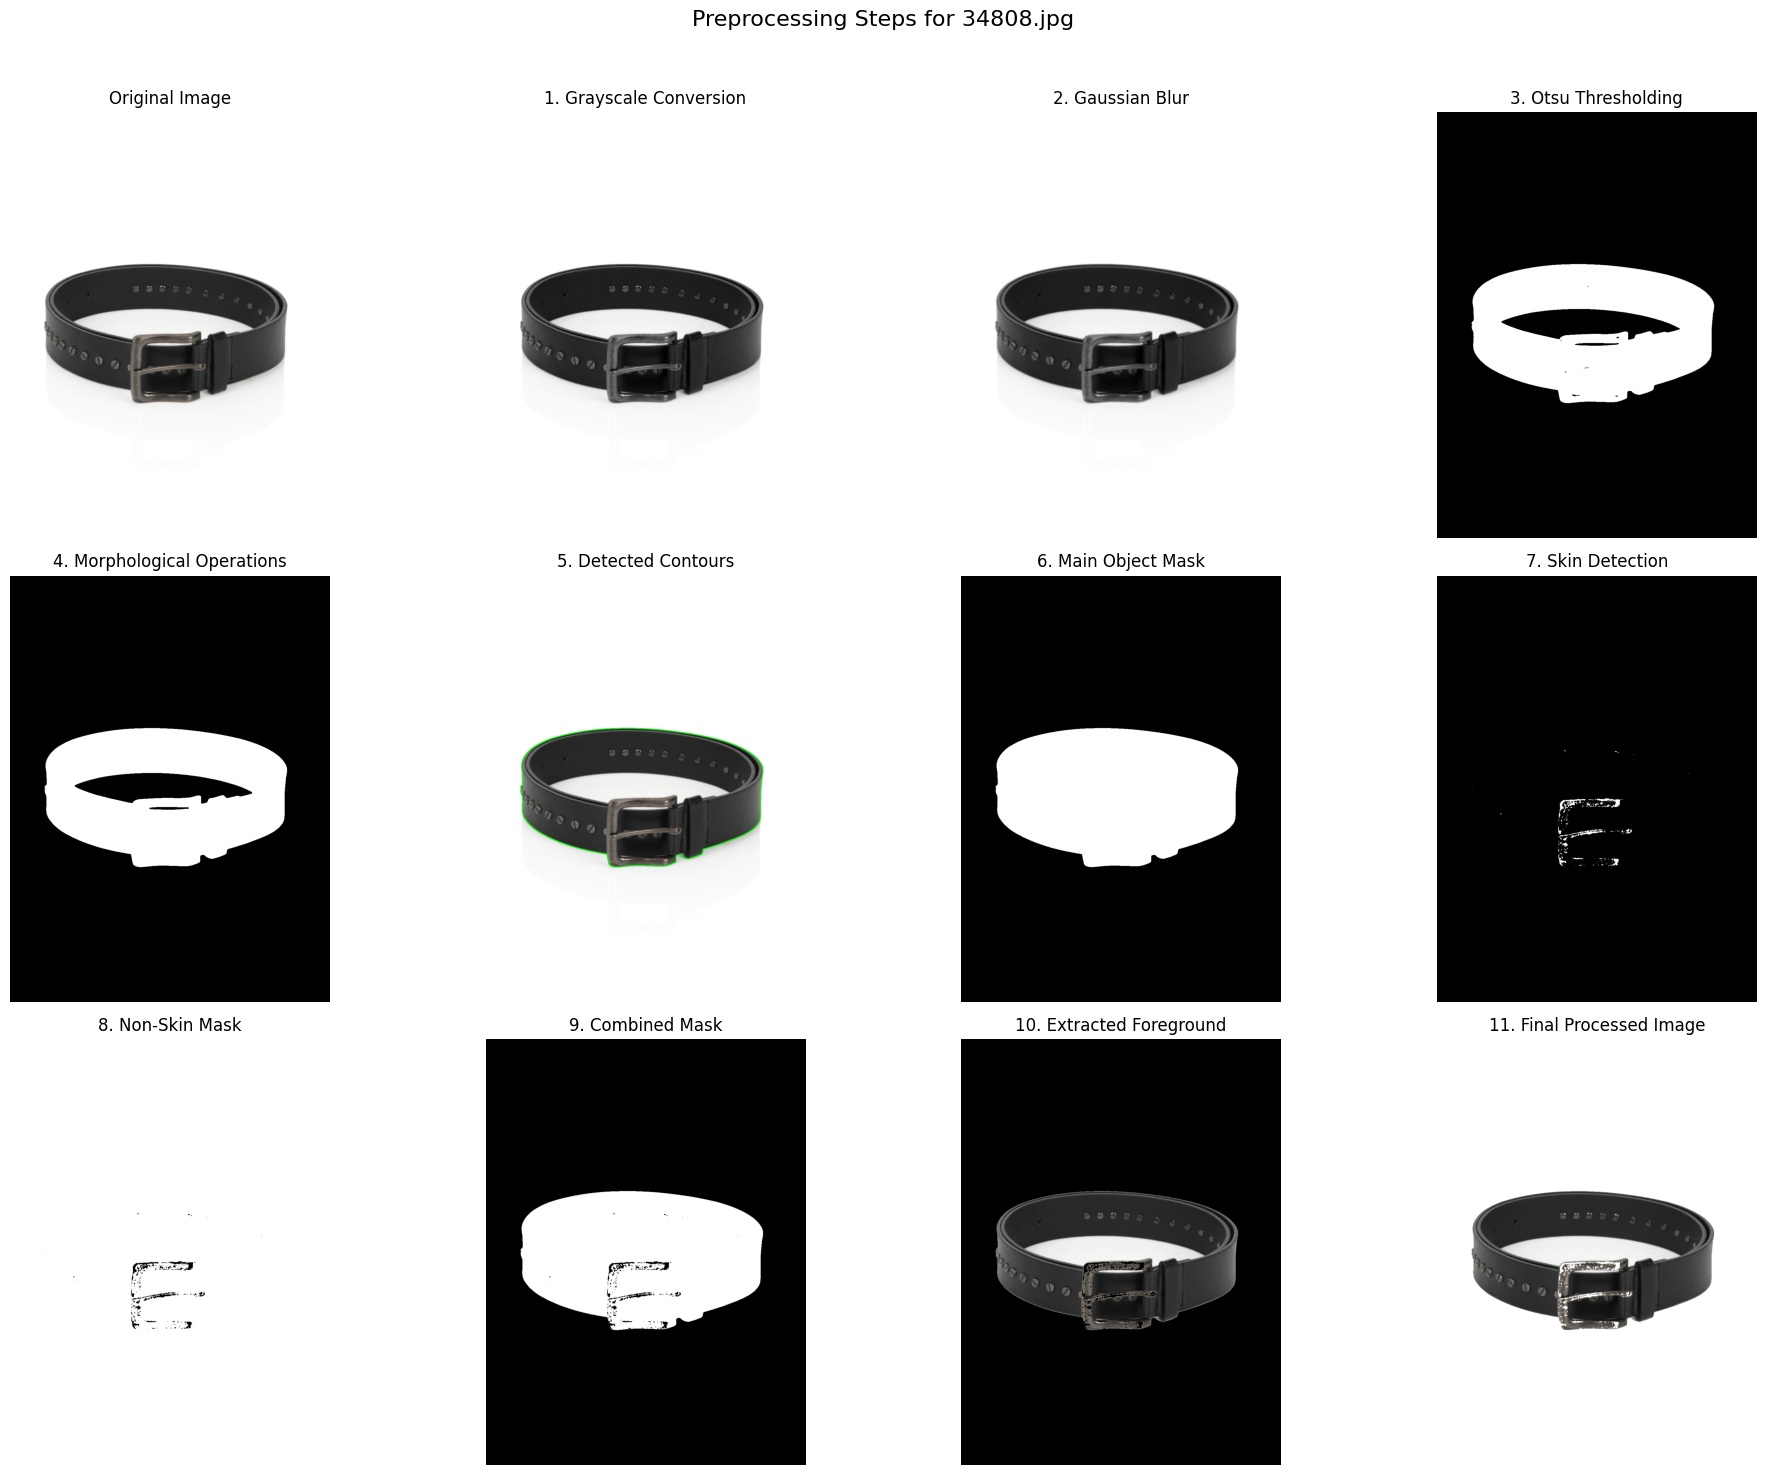

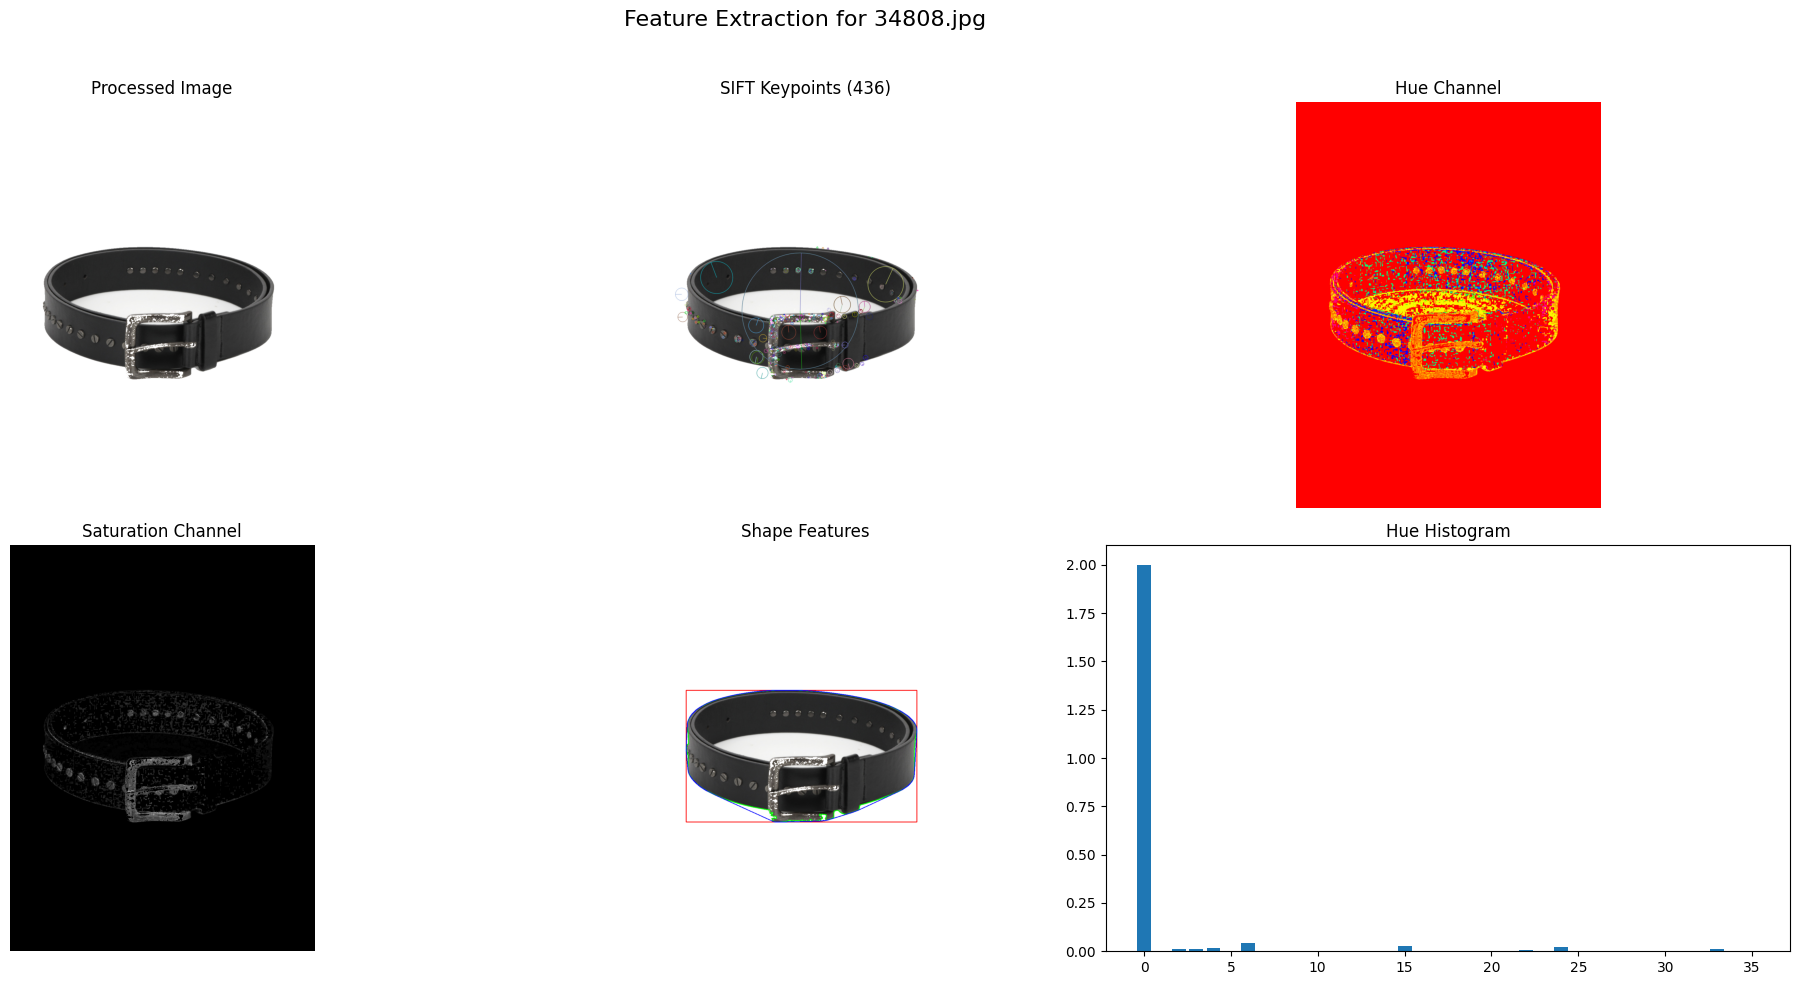

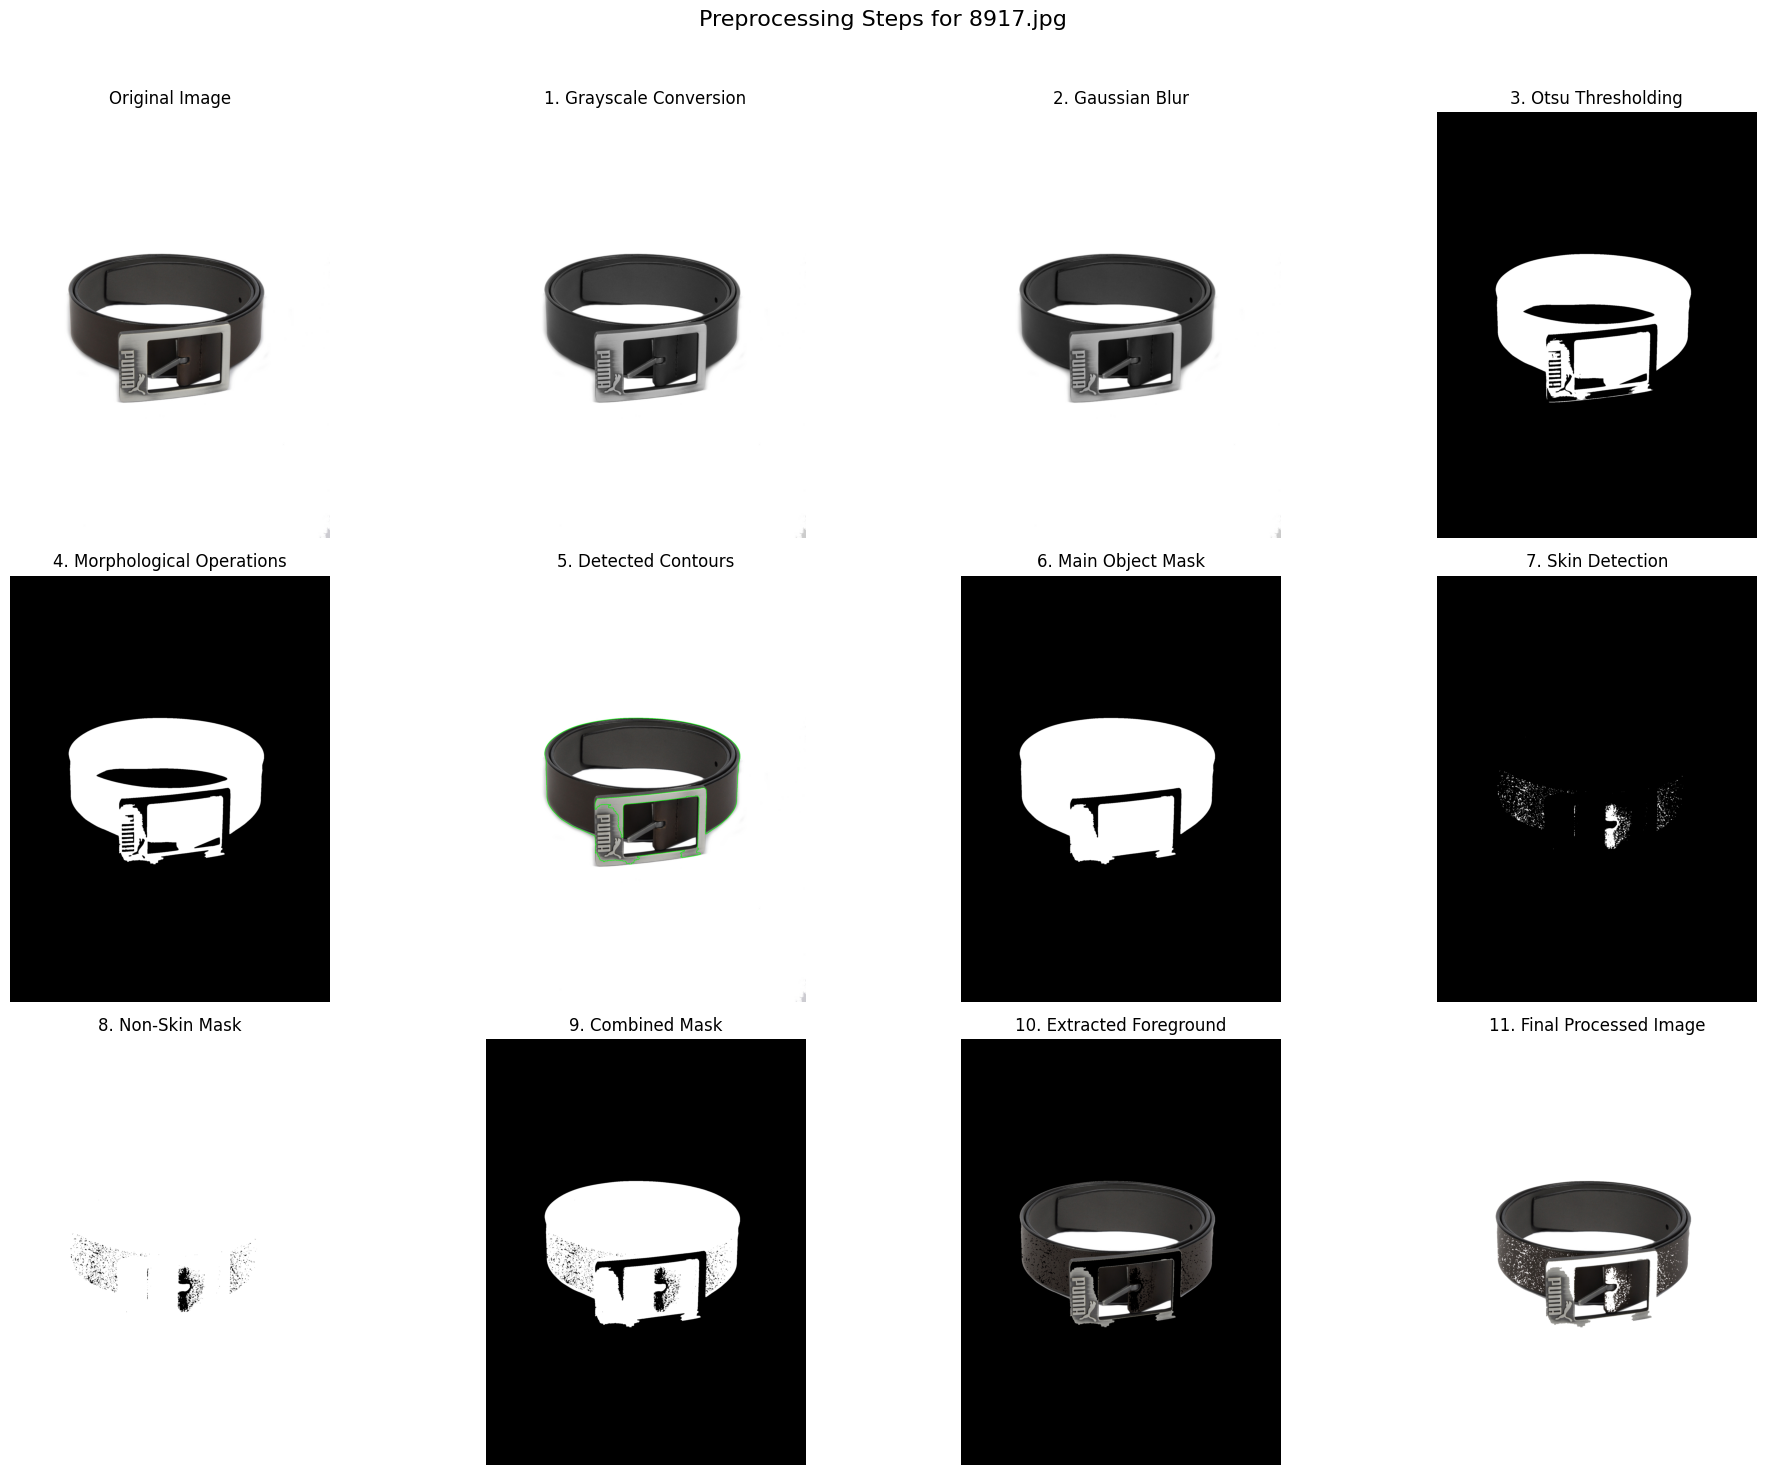

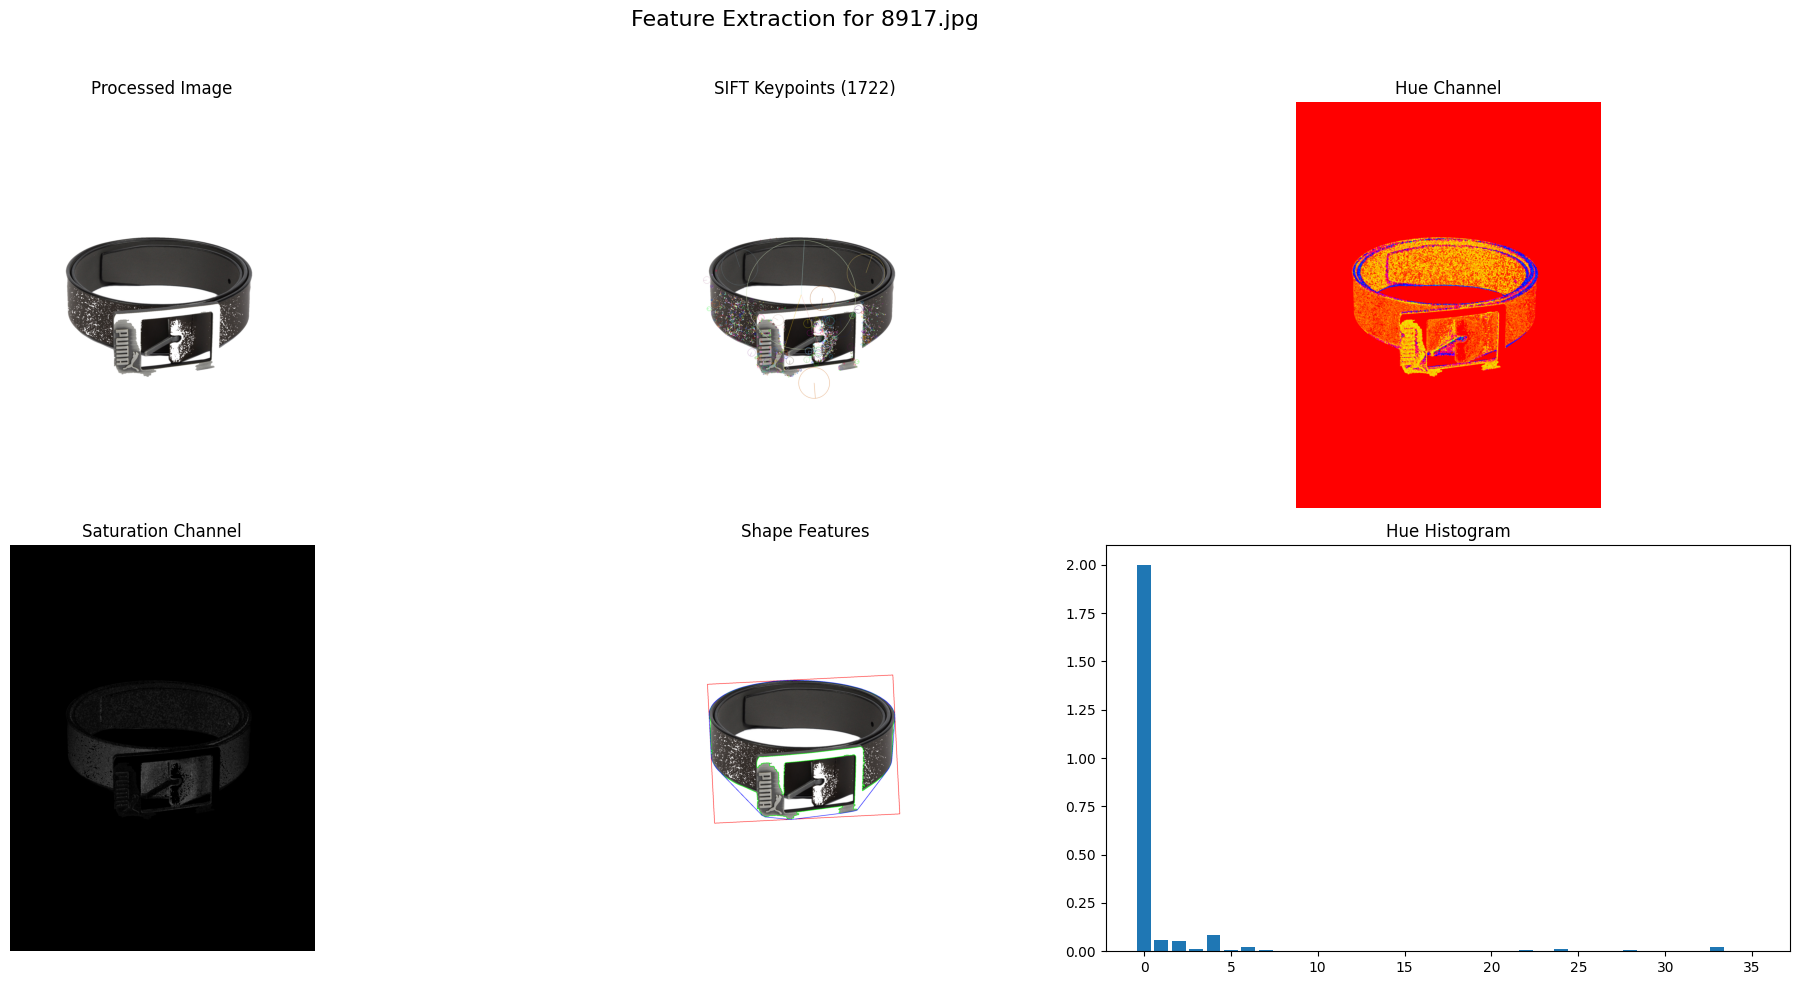

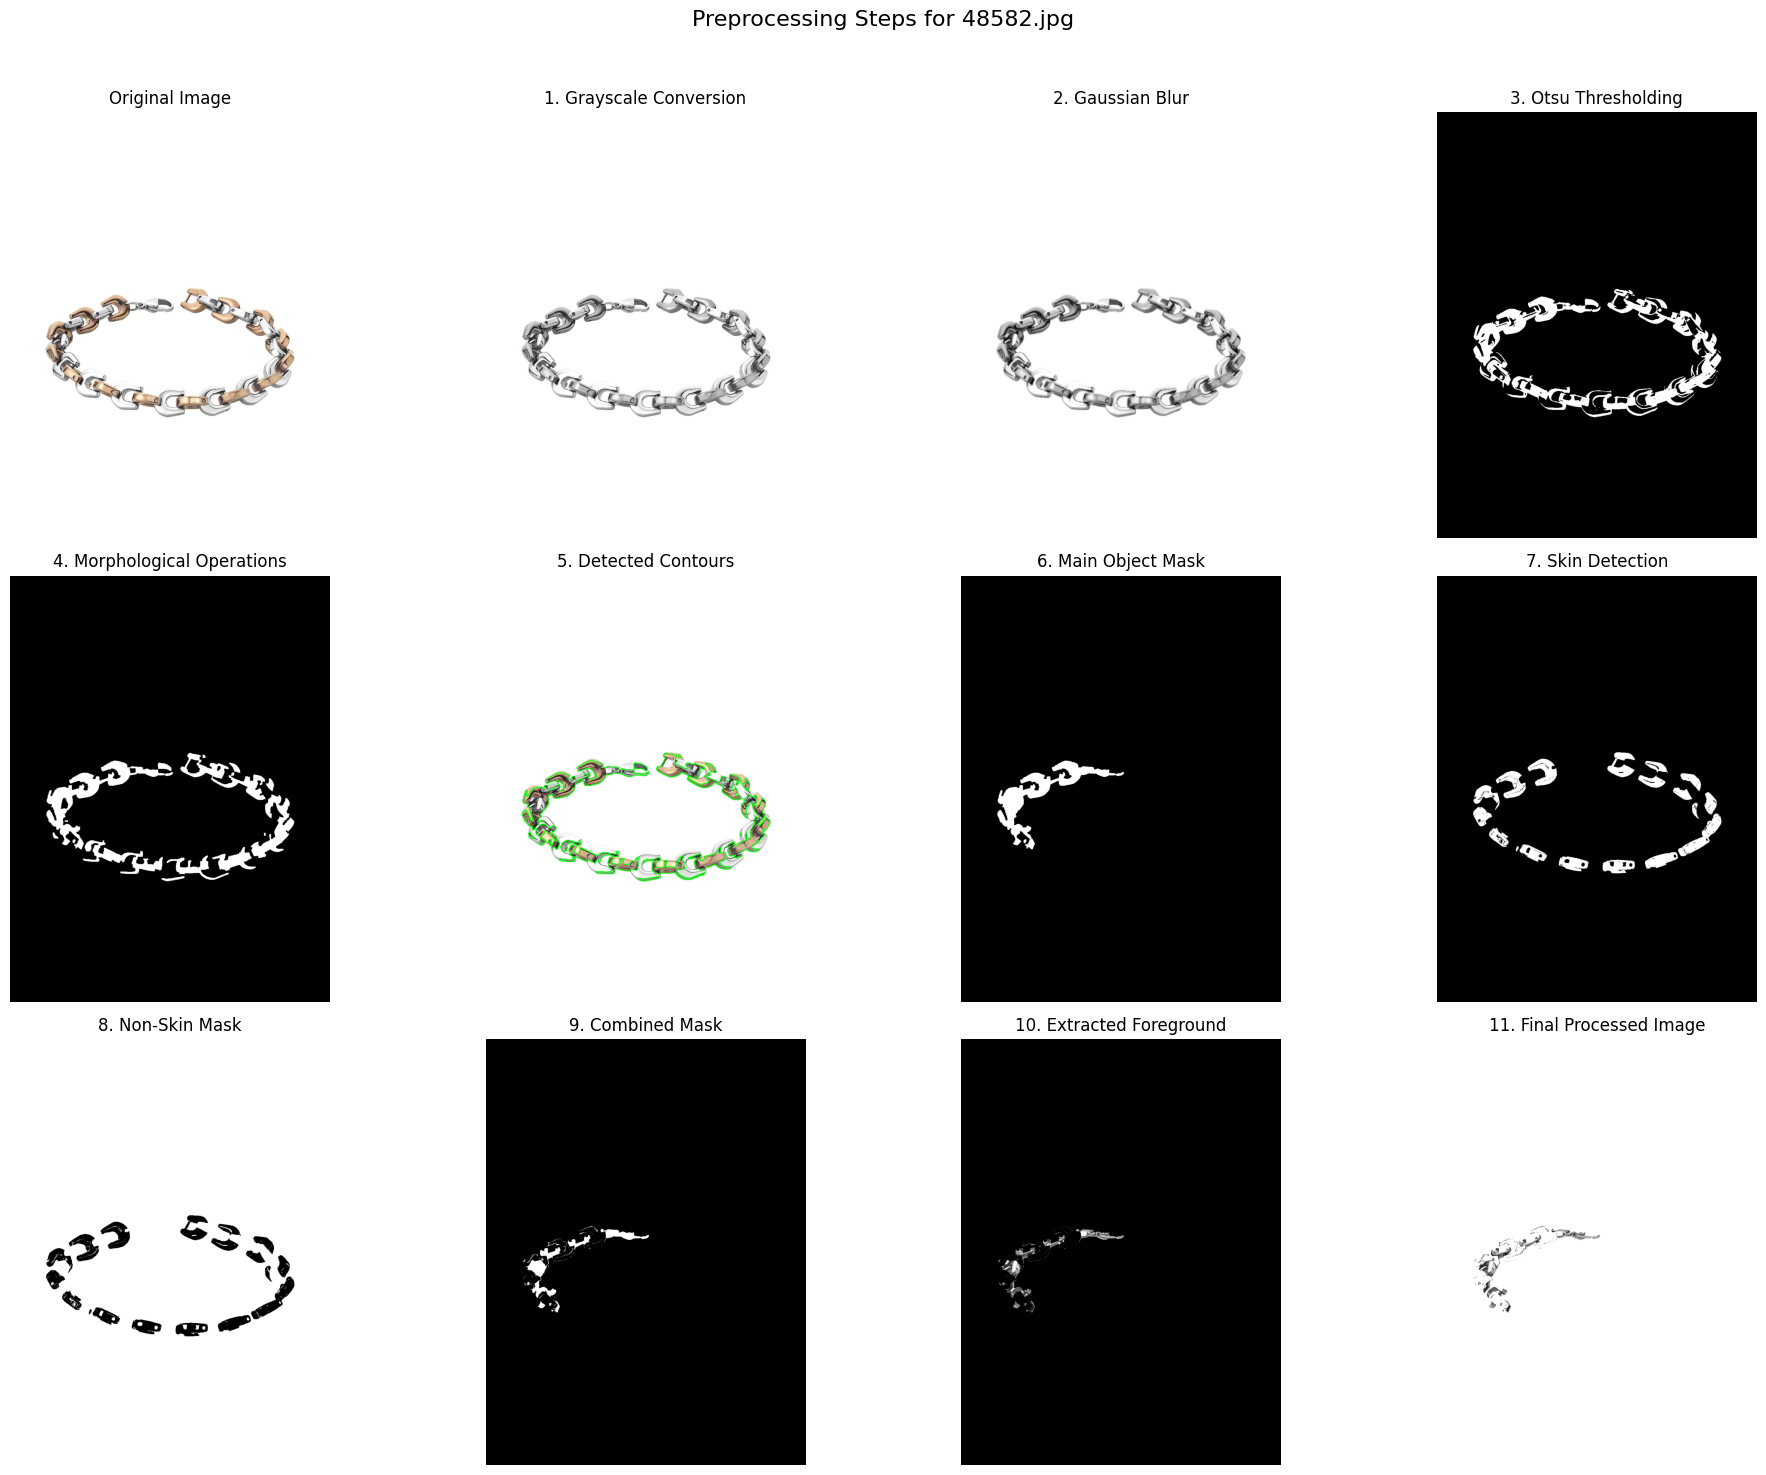

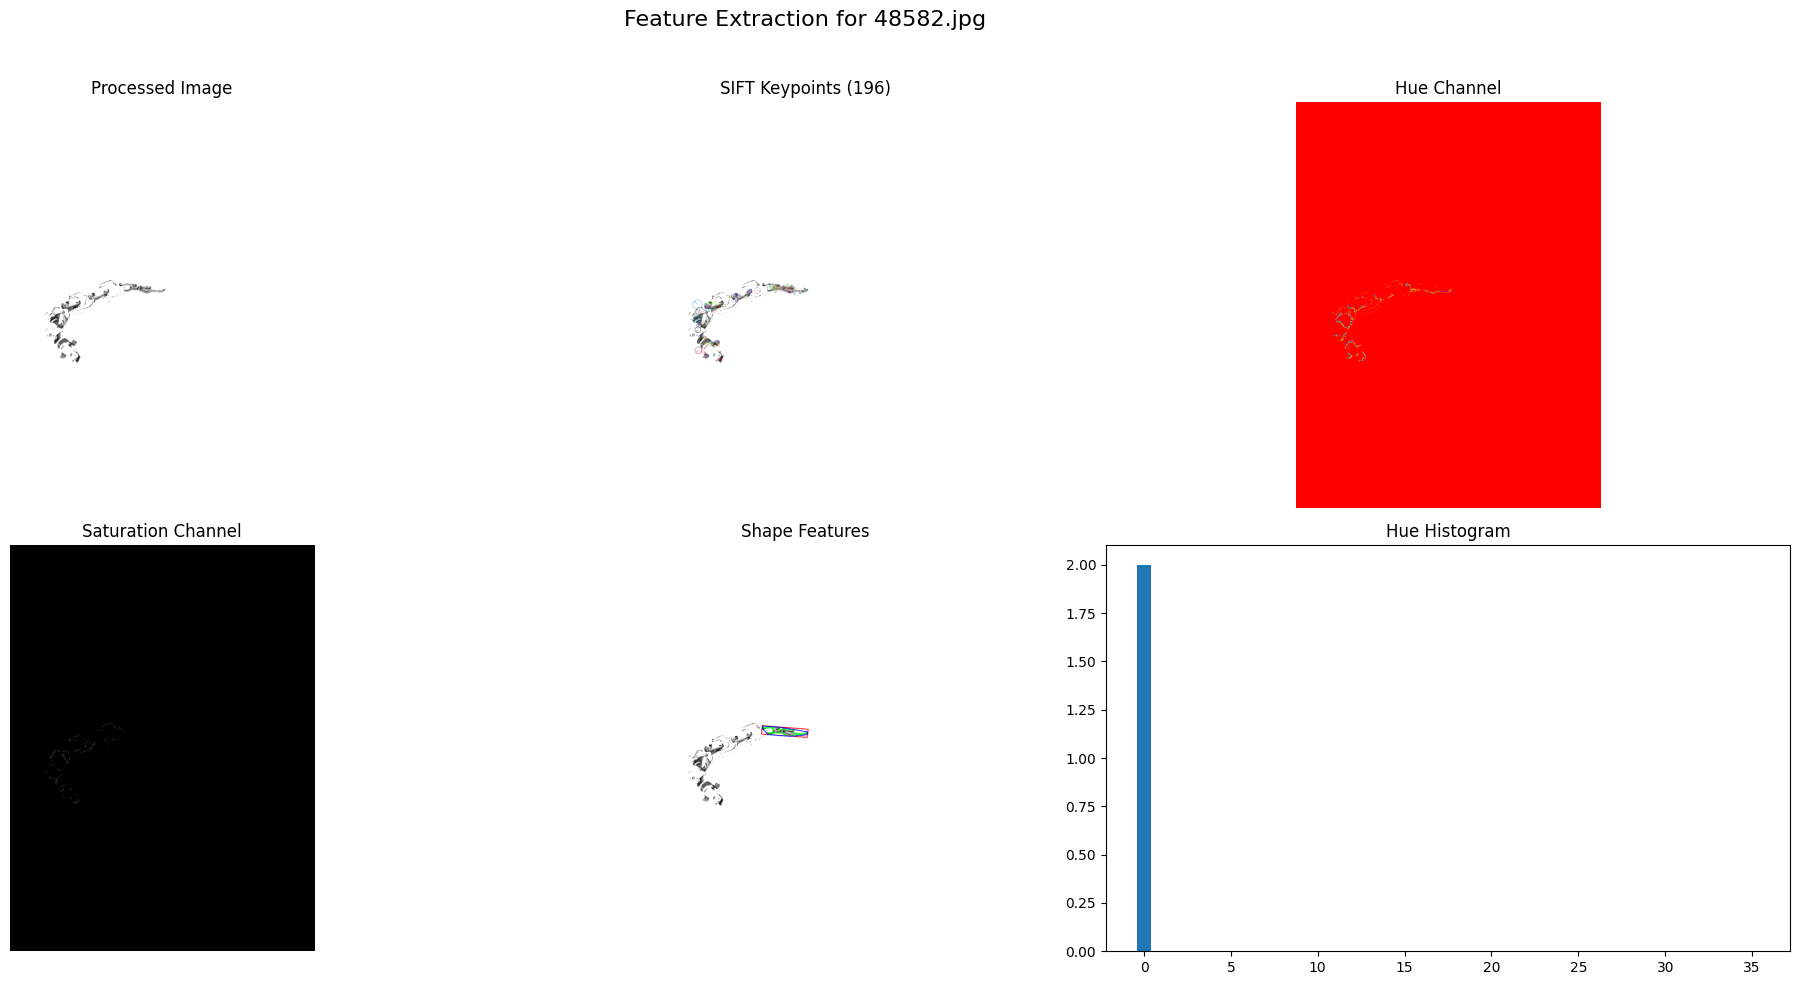

In [ ]:

def visualize_preprocessing_steps(sample_files, dataset_path, feature_data):
    for img_file in sample_files:
        img_path = os.path.join(dataset_path, img_file)
        orig_img = cv2.imread(img_path)
        if orig_img is None:
            print(f"Could not read image: {img_path}")
            continue
        
        # Convert original to RGB for display
        orig_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        
        # Create figure with subplots for each step
        plt.figure(figsize=(20, 15))
        plt.suptitle(f"Preprocessing Steps for {img_file}", fontsize=16)
        
        # Original image
        plt.subplot(3, 4, 1)
        plt.imshow(orig_rgb)
        plt.title("Original Image")
        plt.axis('off')
        
        # Step 1: Convert to grayscale
        gray = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
        plt.subplot(3, 4, 2)
        plt.imshow(gray, cmap='gray')
        plt.title("1. Grayscale Conversion")
        plt.axis('off')
        
        # Step 2: Apply Gaussian blur
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        plt.subplot(3, 4, 3)
        plt.imshow(blurred, cmap='gray')
        plt.title("2. Gaussian Blur")
        plt.axis('off')
        
        # Step 3: Otsu's thresholding
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        plt.subplot(3, 4, 4)
        plt.imshow(binary, cmap='gray')
        plt.title("3. Otsu Thresholding")
        plt.axis('off')
        
        # Step 4: Morphological operations
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        plt.subplot(3, 4, 5)
        plt.imshow(mask, cmap='gray')
        plt.title("4. Morphological Operations")
        plt.axis('off')
        
        # Step 5: Find largest contour
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Visualize contours on original image
        contour_img = orig_rgb.copy()
        cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
        plt.subplot(3, 4, 6)
        plt.imshow(contour_img)
        plt.title("5. Detected Contours")
        plt.axis('off')
        
        # Step 6: Create object mask with largest contour
        object_mask = np.zeros_like(mask)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            cv2.drawContours(object_mask, [largest_contour], 0, 255, -1)
        plt.subplot(3, 4, 7)
        plt.imshow(object_mask, cmap='gray')
        plt.title("6. Main Object Mask")
        plt.axis('off')
        
        # Step 7: Skin detection
        imageYCrCb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2YCrCb)
        min_YCrCb = np.array([0, 133, 77], np.uint8)
        max_YCrCb = np.array([235, 173, 127], np.uint8)
        skinRegion = cv2.inRange(imageYCrCb, min_YCrCb, max_YCrCb)
        plt.subplot(3, 4, 8)
        plt.imshow(skinRegion, cmap='gray')
        plt.title("7. Skin Detection")
        plt.axis('off')
        
        # Step 8: Non-skin mask
        non_skin_mask = cv2.bitwise_not(skinRegion)
        plt.subplot(3, 4, 9)
        plt.imshow(non_skin_mask, cmap='gray')
        plt.title("8. Non-Skin Mask")
        plt.axis('off')
        
        # Step 9: Combined mask
        if contours:
            final_mask = cv2.bitwise_and(object_mask, non_skin_mask)
            plt.subplot(3, 4, 10)
            plt.imshow(final_mask, cmap='gray')
            plt.title("9. Combined Mask")
            plt.axis('off')
            
            # Step 10: Extracted foreground
            foreground = cv2.bitwise_and(orig_img, orig_img, mask=final_mask)
            foreground_rgb = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
            plt.subplot(3, 4, 11)
            plt.imshow(foreground_rgb)
            plt.title("10. Extracted Foreground")
            plt.axis('off')
            
            # Step 11: Final result with white background
            background = np.ones_like(orig_img) * 255
            background_mask = cv2.bitwise_not(final_mask)
            background = cv2.bitwise_and(background, background, mask=background_mask)
            processed_img = cv2.add(foreground, background)
            processed_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)
            plt.subplot(3, 4, 12)
            plt.imshow(processed_rgb)
            plt.title("11. Final Processed Image")
            plt.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
        plt.show()
        
        # Create a second figure for feature extraction visualization
        plt.figure(figsize=(20, 10))
        plt.suptitle(f"Feature Extraction for {img_file}", fontsize=16)
        
        # Show processed image
        if img_file in feature_data and 'processed_img' in feature_data[img_file]:
            proc_img = feature_data[img_file]['processed_img']
            proc_rgb = cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB)
            
            # Processed image
            plt.subplot(2, 3, 1)
            plt.imshow(proc_rgb)
            plt.title("Processed Image")
            plt.axis('off')
            
            # SIFT keypoints
            if 'keypoints' in feature_data[img_file]:
                keypoints = feature_data[img_file]['keypoints']
                img_keypoints = cv2.drawKeypoints(proc_rgb, keypoints, None, 
                                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                plt.subplot(2, 3, 2)
                plt.imshow(img_keypoints)
                plt.title(f"SIFT Keypoints ({len(keypoints)})")
                plt.axis('off')
            
            # Color features - show HSV channels
            hsv_img = cv2.cvtColor(proc_rgb, cv2.COLOR_RGB2HSV)
            h, s, v = cv2.split(hsv_img)
            
            plt.subplot(2, 3, 3)
            plt.imshow(h, cmap='hsv')
            plt.title("Hue Channel")
            plt.axis('off')
            
            plt.subplot(2, 3, 4)
            plt.imshow(s, cmap='gray')
            plt.title("Saturation Channel")
            plt.axis('off')
            
            # Shape features - show contours with improved threshold
            shape_viz = proc_rgb.copy()
            gray = cv2.cvtColor(proc_img, cv2.COLOR_BGR2GRAY)
            # Apply Gaussian blur to reduce noise
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            # Use Otsu's thresholding with inverse (for dark objects on light background)
            _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
            # Clean up the mask
            kernel = np.ones((3, 3), np.uint8)
            binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
            binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

            # Find contours
            contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            if contours:
                # Get largest contour
                main_contour = max(contours, key=cv2.contourArea)
                
                # Draw contour in green
                cv2.drawContours(shape_viz, [main_contour], -1, (0, 255, 0), 2)
                
                # Draw bounding rectangle in blue
                rect = cv2.minAreaRect(main_contour)
                box = cv2.boxPoints(rect)
                box = np.int_(box)
                cv2.drawContours(shape_viz, [box], 0, (255, 0, 0), 2)
                
                # Draw convex hull in red
                hull = cv2.convexHull(main_contour)
                cv2.drawContours(shape_viz, [hull], 0, (0, 0, 255), 2)
                
                # Write shape metrics on the image
                if 'shape_features' in feature_data[img_file]:
                    shape_dict = feature_data[img_file]['shape_features']
                    y_pos = 30
                    for key, value in shape_dict.items():
                        # Check if value is a number that can be formatted with .2f
                        try:
                            # Try to convert to float and format
                            formatted_value = f"{float(value):.2f}"
                        except (ValueError, TypeError):
                            # If conversion fails, use the original value as a string
                            formatted_value = str(value)
                            
                        text = f"{key}: {formatted_value}"
                        cv2.putText(shape_viz, text, (10, y_pos), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                        y_pos += 25
                
                plt.subplot(2, 3, 5)
                plt.imshow(shape_viz)
                plt.title("Shape Features")
                plt.axis('off')
            
            # Color histogram
            if 'color_features' in feature_data[img_file]:
                color_hist = feature_data[img_file]['color_features'][:36]  # Hue histogram
                plt.subplot(2, 3, 6)
                plt.bar(range(len(color_hist)), color_hist)
                plt.title("Hue Histogram")
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
        plt.show()

# Visualize preprocessing steps for a few sample images
if len(feature_data) > 0:
    sample_size = min(3, len(feature_data))
    sample_files = list(feature_data.keys())[:sample_size]
    visualize_preprocessing_steps(sample_files, dataset_path, feature_data)

# Create Bag of Visual Words representation with enhanced features and no PCA

Creating visual vocabulary...
Vocabulary creation completed with 500 visual words


Creating feature vectors:   0%|          | 0/743 [00:00<?, ?it/s]

Sample shape features for 34808.jpg: {'aspect_ratio': 0.75, 'extent': 1.0, 'solidity': 1.0, 'equivalent_diameter': np.float64(1406.0351523197908), 'convexity': 1.0, 'cluster': 1, 'image_file': np.str_('34808.jpg')}
Converted to array: [7.50000000e-01 1.00000000e+00 1.00000000e+00 1.40603515e+03
 1.00000000e+00 1.00000000e+00 0.00000000e+00]
Created feature vectors for 743 images
Feature vector dimension: 3063
Standardizing features (maintaining all dimensions)...


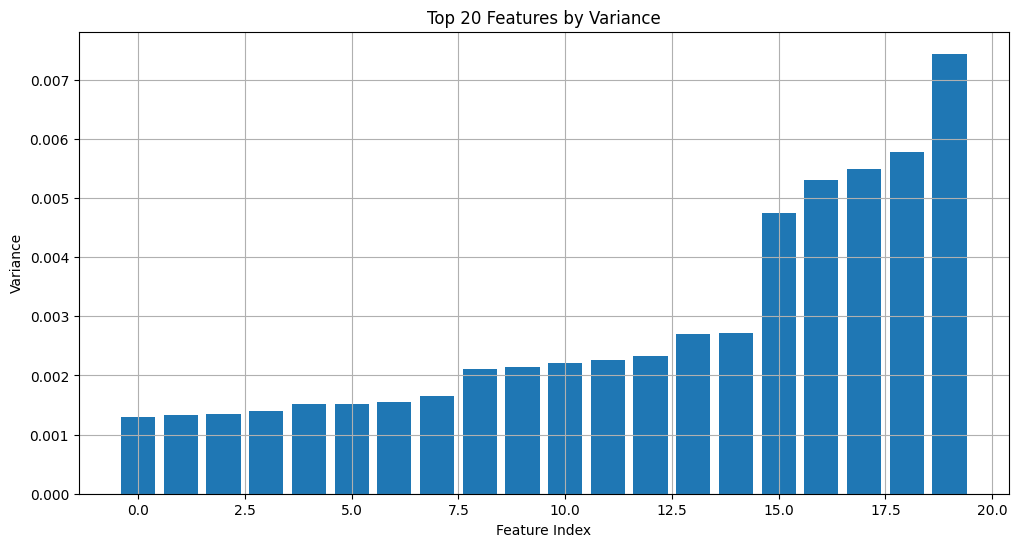

Using full feature vectors with 3063 dimensions
PCA dimensionality reduction has been disabled to preserve shape and color information
Final feature vector shape: (743, 3063)


In [ ]:

def create_bag_of_visual_words(feature_data, visualize=True):
    # Collect all descriptors for vocabulary creation
    all_descriptors = []
    for img_file, data in feature_data.items():
        if 'descriptors' in data and data['descriptors'] is not None:
            all_descriptors.append(data['descriptors'])

    # Combine all descriptors
    if all_descriptors:
        all_descriptors = np.vstack(all_descriptors)
        
        # Create vocabulary using K-means with increased vocabulary size
        print("Creating visual vocabulary...")
        num_words = 500  # Increased from 100 for finer discrimination
        kmeans = KMeans(n_clusters=num_words, random_state=42, n_init=10)
        kmeans.fit(all_descriptors)
        print(f"Vocabulary creation completed with {num_words} visual words")
        
        # Create histogram of visual words for each image
        image_features = {}
        for img_file, data in tqdm(feature_data.items(), desc="Creating feature vectors"):
            if 'descriptors' in data and data['descriptors'] is not None and len(data['descriptors']) > 0:
                # Initialize feature vector
                feature_vector = []
                
                # 1. SIFT-based Bag of Words features
                histogram = np.zeros(num_words)
                cluster_ids = kmeans.predict(data['descriptors'])
                for cluster_id in cluster_ids:
                    histogram[cluster_id] += 1
                
                # Normalize histogram
                if np.sum(histogram) > 0:
                    histogram = histogram / np.sum(histogram)
                
                # Add SIFT histogram to feature vector with weight
                sift_weight = 1.0  # Reduced weight for SIFT features (baseline)
                feature_vector = histogram * sift_weight
                
                # 2. Add texture features if available
                if 'texture_features' in data and data['texture_features'] is not None:
                    texture_features = data['texture_features']
                    # Normalize texture features
                    texture_norm = texture_features
                    if np.sum(texture_features) > 0:
                        texture_norm = texture_features / np.sum(texture_features)
                    
                    # Apply weight to texture features (reduced weight)
                    texture_weight = 0.8  # Reduced weight for texture
                    weighted_texture = texture_norm * texture_weight
                    
                    # Concatenate with feature vector
                    feature_vector = np.concatenate([feature_vector, weighted_texture])
                
                # 3. Add shape features with significantly higher weight for accessories
                if 'shape_features' in data and data['shape_features'] is not None:
                    # Convert dictionary to array
                    shape_dict = data['shape_features']
                    
                    # Create array from shape features, ensuring they're numeric
                    shape_values = []
                    for key, value in shape_dict.items():
                        try:
                            shape_values.append(float(value))
                        except (ValueError, TypeError):
                            # Use 0 for non-numeric values
                            shape_values.append(0.0)
                    
                    shape_array = np.array(shape_values)
                    
                    # Print sample of shape features for debugging
                    if img_file == list(feature_data.keys())[0]:
                        print(f"Sample shape features for {img_file}: {shape_dict}")
                        print(f"Converted to array: {shape_array}")
                    
                    # Scale shape features to handle different ranges
                    # Avoid division by zero
                    if np.sum(np.abs(shape_array)) > 0:
                        shape_norm = shape_array / np.sum(np.abs(shape_array))
                    else:
                        shape_norm = shape_array
                    
                    # Apply much higher weight for shape features (critical for accessories)
                    shape_weight = 6.0  # Significantly increased from 3.0
                    weighted_shape = shape_norm * shape_weight
                    
                    # Concatenate with feature vector
                    feature_vector = np.concatenate([feature_vector, weighted_shape])
                
                # 4. Add color features with highest weight for accessories
                if 'color_features' in data and data['color_features'] is not None:
                    color_features = data['color_features']
                    
                    # Normalize color features
                    if np.sum(np.abs(color_features)) > 0:
                        color_norm = color_features / np.sum(np.abs(color_features))
                    else:
                        color_norm = color_features
                    
                    # Apply weight for color features (most important for accessories)
                    color_weight = 5.0  # Increased from 3.5
                    weighted_color = color_norm * color_weight
                    
                    # Concatenate with feature vector
                    feature_vector = np.concatenate([feature_vector, weighted_color])
                
                # Store the combined feature vector
                image_features[img_file] = feature_vector
        
        print(f"Created feature vectors for {len(image_features)} images")
        
        # Convert to numpy array for further processing
        if image_features:
            feature_vectors = np.array(list(image_features.values()))
            image_files = list(image_features.keys())
            
            # Print feature vector dimensions
            print(f"Feature vector dimension: {feature_vectors.shape[1]}")
            
            # Optional: standardize features (but keep all dimensions)
            from sklearn.preprocessing import StandardScaler
            print("Standardizing features (maintaining all dimensions)...")
            scaler = StandardScaler()
            feature_vectors_scaled = scaler.fit_transform(feature_vectors)
            
            # Visualize feature importance
            if visualize:
                # Show variance of each feature
                feature_variance = np.var(feature_vectors, axis=0)
                
                # Get top 20 features by variance
                top_indices = np.argsort(feature_variance)[-20:]
                top_variances = feature_variance[top_indices]
                
                plt.figure(figsize=(12, 6))
                plt.bar(range(len(top_variances)), top_variances)
                plt.title('Top 20 Features by Variance')
                plt.xlabel('Feature Index')
                plt.ylabel('Variance')
                plt.grid(True)
                plt.show()
            
            print(f"Using full feature vectors with {feature_vectors_scaled.shape[1]} dimensions")
            print("PCA dimensionality reduction has been disabled to preserve shape and color information")
            
            # Return the standardized feature vectors (no PCA)
            return feature_vectors_scaled, image_files, kmeans, scaler
        else:
            print("No valid feature vectors created.")
            return None, None, None, None
    else:
        print("No descriptors found in the dataset.")
        return None, None, None, None

# Run the feature extraction
feature_vectors_scaled, image_files, kmeans_model, scaler_model = create_bag_of_visual_words(feature_data)

# Save the models and feature vectors for later use
if feature_vectors_scaled is not None:
    # Create a results dictionary
    results = {
        'feature_vectors': feature_vectors_scaled,
        'image_files': image_files,
        'kmeans_model': kmeans_model,
        'scaler_model': scaler_model
    }
    
    print(f"Final feature vector shape: {feature_vectors_scaled.shape}")
    
    # Create a global variable for the feature vectors to use in later blocks
    # This replaces the previous feature_vectors_pca
    feature_vectors_pca = feature_vectors_scaled  # Keep the name for compatibility with later code

# Find optimal number of clusters using multiple metrics

Finding optimal number of clusters...
Evaluating clusters using Silhouette Score...


Silhouette Analysis:   0%|          | 0/39 [00:00<?, ?it/s]

k=2, silhouette score=0.7943
k=3, silhouette score=0.0853
k=4, silhouette score=0.0126
k=5, silhouette score=0.0298
k=6, silhouette score=-0.0175
k=7, silhouette score=-0.0222
k=8, silhouette score=-0.0434
k=9, silhouette score=-0.0160
k=10, silhouette score=-0.0180
k=11, silhouette score=-0.0138
k=12, silhouette score=-0.0224
k=13, silhouette score=-0.0160
k=14, silhouette score=-0.0241
k=15, silhouette score=-0.0188
k=16, silhouette score=-0.0177
k=17, silhouette score=-0.0093
k=18, silhouette score=-0.0225
k=19, silhouette score=-0.0144
k=20, silhouette score=-0.0166
k=21, silhouette score=-0.0040
k=22, silhouette score=-0.0174
k=23, silhouette score=-0.0179
k=24, silhouette score=-0.0236
k=25, silhouette score=-0.0348
k=26, silhouette score=-0.0082
k=27, silhouette score=-0.0130
k=28, silhouette score=-0.0308
k=29, silhouette score=-0.0423
k=30, silhouette score=-0.0287
k=31, silhouette score=-0.0327
k=32, silhouette score=-0.0258
k=33, silhouette score=-0.0203
k=34, silhouette sco

Elbow Analysis:   0%|          | 0/39 [00:00<?, ?it/s]

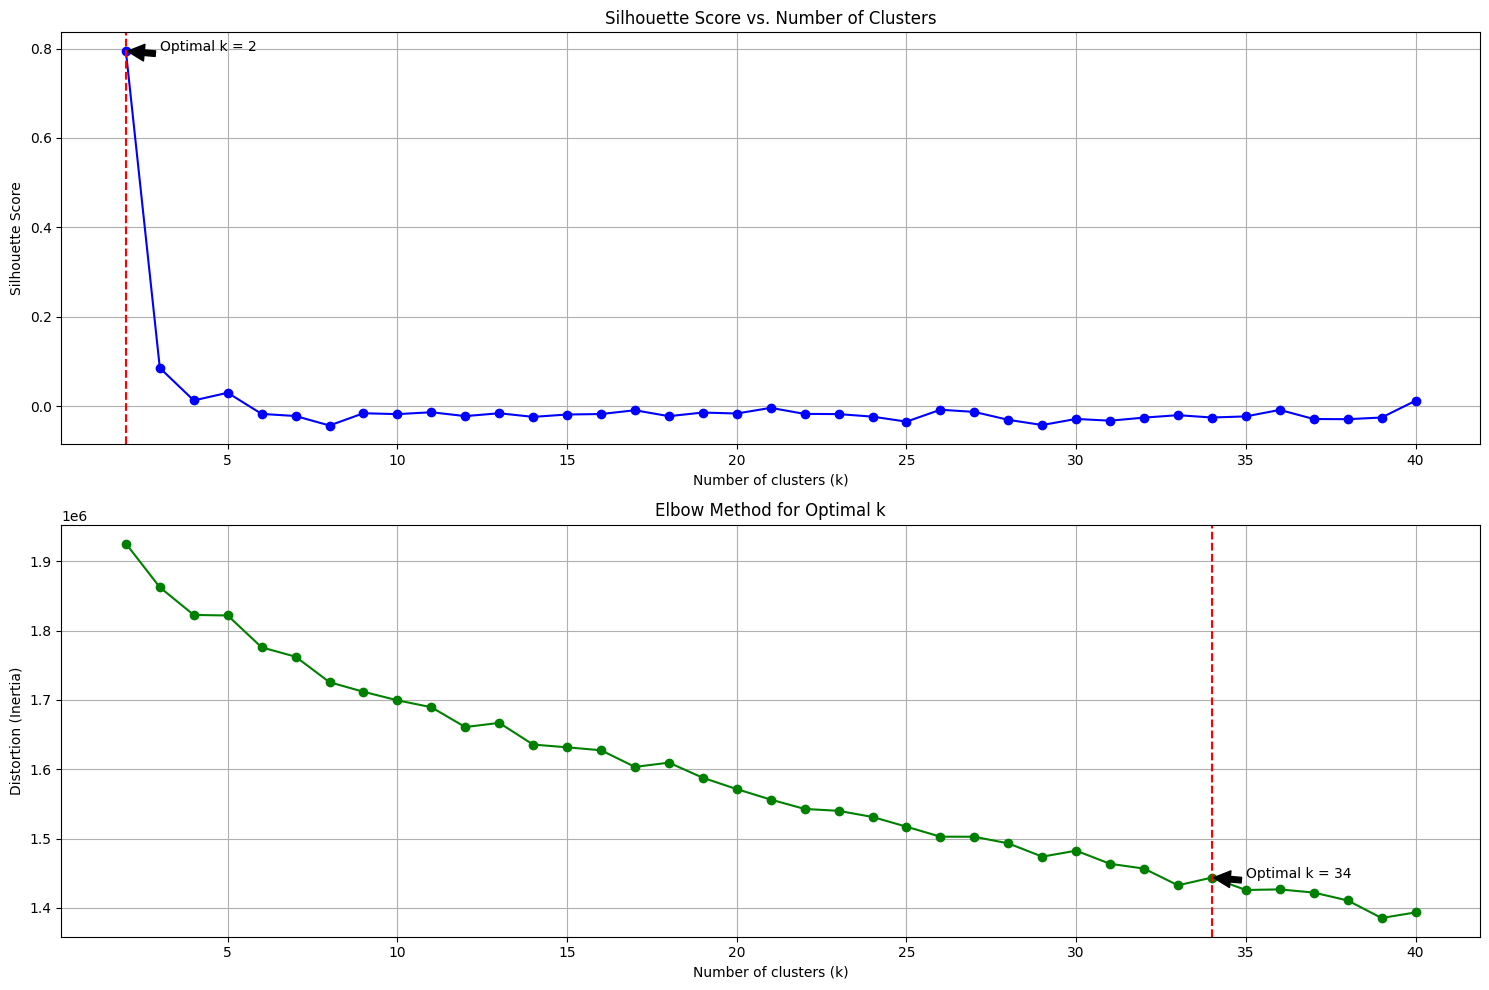

Recommended number of clusters: 2
Optimal number of clusters from analysis: 2
Performing final clustering with k=2...
Clustering complete. Found 2 clusters
Cluster 0: 742 items
Cluster 1: 1 items


In [ ]:

def find_optimal_clusters(data, max_k=40, methods=['silhouette', 'elbow']):
    """
    Find the optimal number of clusters using multiple metrics
    
    Parameters:
    -----------
    data : numpy.ndarray
        Feature vectors to cluster
    max_k : int
        Maximum number of clusters to consider
    methods : list
        Methods to use for finding optimal clusters
        
    Returns:
    --------
    dict
        Dictionary with optimal k values for each method
    """
    # Ensure max_k doesn't exceed number of samples
    max_k = min(max_k, len(data) - 1)
    
    # Need at least 2 clusters
    if max_k < 2:
        print("Not enough samples for clustering analysis")
        return {'silhouette': 2, 'elbow': 2}
    
    # Range of k values to test
    k_values = range(2, max_k + 1)
    results = {}
    
    # Prepare plot
    plt.figure(figsize=(15, 10))
    
    # Silhouette Method
    if 'silhouette' in methods:
        print("Evaluating clusters using Silhouette Score...")
        silhouette_scores = []
        
        for k in tqdm(k_values, desc="Silhouette Analysis"):
            # Perform K-means clustering
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(data)
            
            # Calculate silhouette score
            score = silhouette_score(data, cluster_labels)
            silhouette_scores.append(score)
            print(f"k={k}, silhouette score={score:.4f}")
        
        # Find k with the highest silhouette score
        optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
        results['silhouette'] = optimal_k_silhouette
        
        # Plot silhouette scores
        plt.subplot(2, 1, 1)
        plt.plot(k_values, silhouette_scores, 'o-', color='blue')
        plt.axvline(x=optimal_k_silhouette, color='red', linestyle='--')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score vs. Number of Clusters')
        plt.grid(True)
        plt.annotate(f'Optimal k = {optimal_k_silhouette}', 
                    xy=(optimal_k_silhouette, silhouette_scores[optimal_k_silhouette-2]),
                    xytext=(optimal_k_silhouette+1, silhouette_scores[optimal_k_silhouette-2]),
                    arrowprops=dict(facecolor='black', shrink=0.05))
    
    # Elbow Method
    if 'elbow' in methods:
        print("Evaluating clusters using Elbow Method...")
        distortions = []
        
        for k in tqdm(k_values, desc="Elbow Analysis"):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(data)
            distortions.append(kmeans.inertia_)
        
        # Calculate the rate of decrease in distortion
        deltas = np.array([distortions[i-1] - distortions[i] for i in range(1, len(distortions))])
        
        # Normalize to make comparable
        normalized_deltas = deltas / distortions[0]
        
        # Find the elbow point (where the rate of decrease slows down significantly)
        elbow_index = np.argmin(normalized_deltas) + 1  # +1 as we started from difference
        optimal_k_elbow = k_values[elbow_index]
        results['elbow'] = optimal_k_elbow
        
        # Plot distortions
        plt.subplot(2, 1, 2)
        plt.plot(k_values, distortions, 'o-', color='green')
        plt.axvline(x=optimal_k_elbow, color='red', linestyle='--')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Distortion (Inertia)')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True)
        plt.annotate(f'Optimal k = {optimal_k_elbow}', 
                    xy=(optimal_k_elbow, distortions[optimal_k_elbow-2]),
                    xytext=(optimal_k_elbow+1, distortions[optimal_k_elbow-2]),
                    arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.tight_layout()
    plt.show()
    
    # Choose final optimal k (prioritize silhouette if available)
    if 'silhouette' in results:
        final_k = results['silhouette']
    elif 'elbow' in results:
        final_k = results['elbow']
    else:
        final_k = 5  # Default fallback
    
    print(f"Recommended number of clusters: {final_k}")
    return results, final_k

# Run the cluster analysis if we have feature vectors
if 'feature_vectors_pca' in locals() and feature_vectors_pca is not None:
    max_clusters = min(40, len(feature_vectors_pca) - 1)
    if max_clusters >= 2:
        print("Finding optimal number of clusters...")
        cluster_results, optimal_k = find_optimal_clusters(
            feature_vectors_pca, 
            max_clusters,
            methods=['silhouette', 'elbow']
        )
        print(f"Optimal number of clusters from analysis: {optimal_k}")
    else:
        print("Not enough samples for clustering analysis")
        optimal_k = 2  # Default value
else:
    print("Feature vectors not available for cluster analysis")
    optimal_k = 5  # Default fallback value

# Perform final clustering with optimal k
if 'feature_vectors_pca' in locals() and feature_vectors_pca is not None:
    print(f"Performing final clustering with k={optimal_k}...")
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = final_kmeans.fit_predict(feature_vectors_pca)
    
    # Add cluster labels to a dictionary with image filenames
    clustering_results = {}
    for i, img_file in enumerate(image_files):
        clustering_results[img_file] = cluster_labels[i]
    
    print(f"Clustering complete. Found {optimal_k} clusters")
    
    # Count items in each cluster
    cluster_counts = np.bincount(cluster_labels)
    for cluster_id in range(optimal_k):
        print(f"Cluster {cluster_id}: {cluster_counts[cluster_id]} items")

# K-means clustering with visualization and analysis

Performing K-means clustering with 2 clusters...

Cluster distribution:
Cluster 0: 742 items (99.9%)
Cluster 1: 1 items (0.1%)


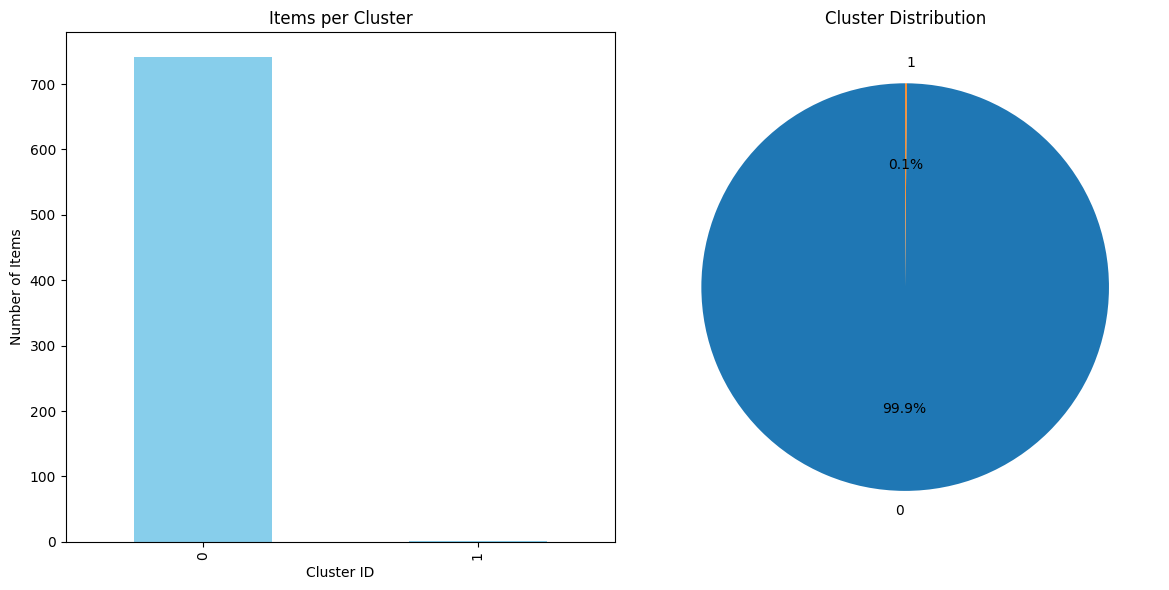

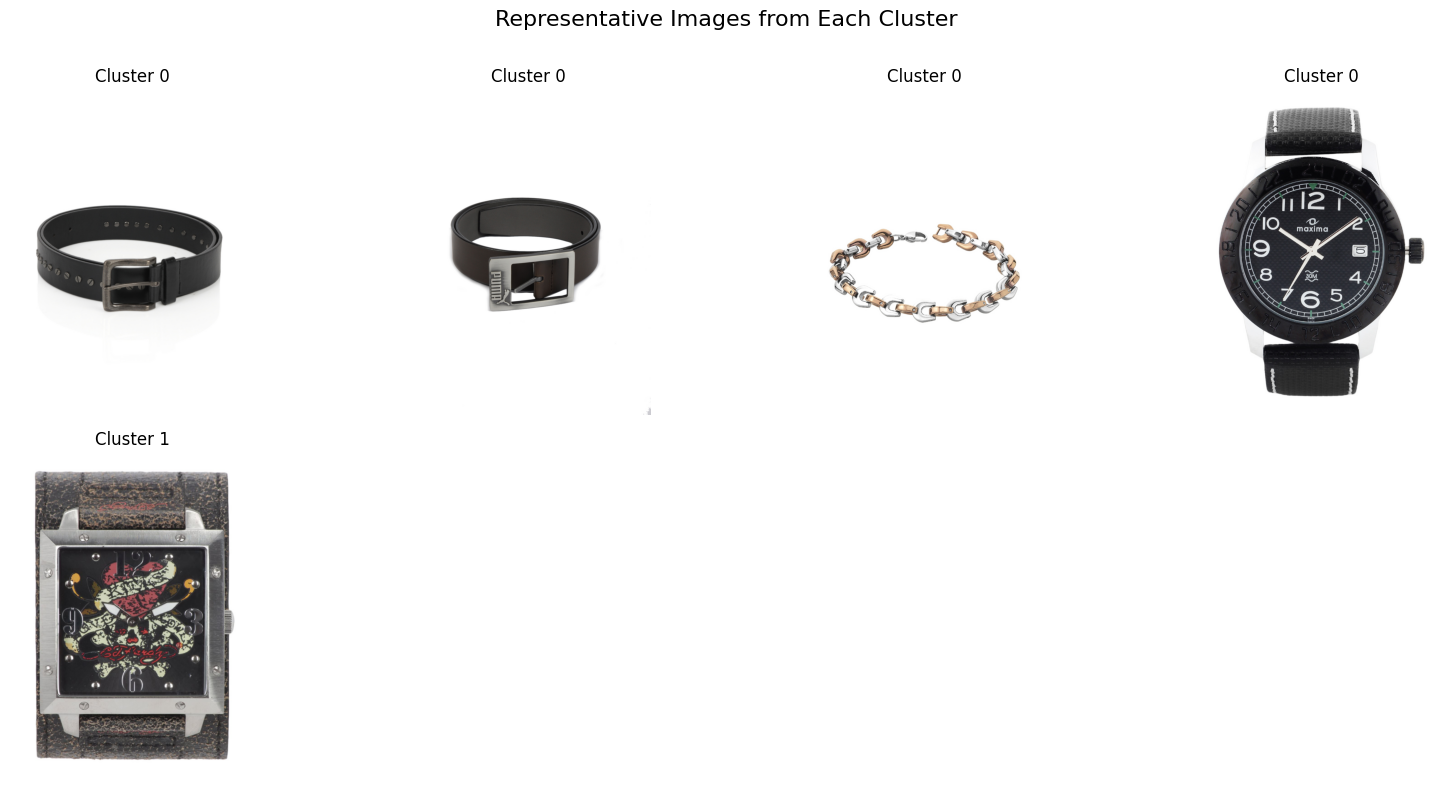

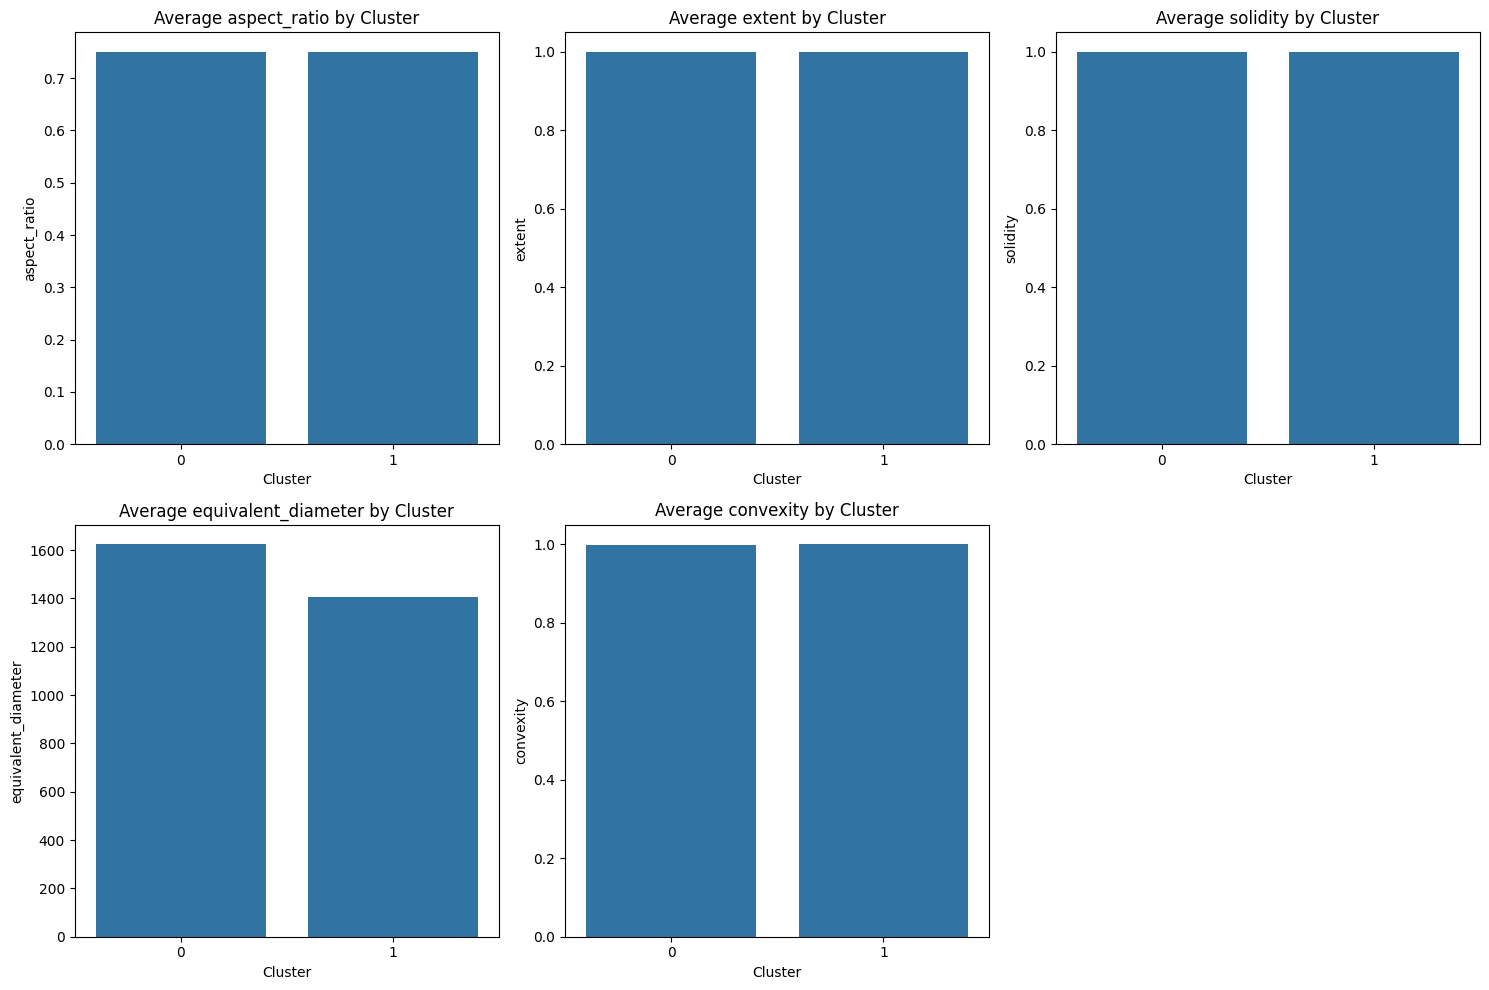


Cluster Characteristics:

Cluster 0:
  Distinctive features:
    - equivalent_diameter: 1.07x average
    - aspect_ratio: 1.00x average
    - extent: 1.00x average

Cluster 1:
  Distinctive features:
    - convexity: 1.00x average
    - extent: 1.00x average
    - solidity: 1.00x average
Clustering results saved to 'accessory_clusters.csv'

Sample of clustering results:
  image_file  cluster
0  34808.jpg        0
1   8917.jpg        0
2  48582.jpg        0
3  45027.jpg        0
4  24867.jpg        0


In [ ]:


def perform_clustering_analysis(feature_vectors, image_files, optimal_k, dataset_path=None, feature_data=None):
    """
    Perform K-means clustering and generate visualizations and analysis
    
    Parameters:
    -----------
    feature_vectors : numpy.ndarray
        PCA-reduced feature vectors
    image_files : list
        List of image filenames corresponding to feature vectors
    optimal_k : int
        Optimal number of clusters to use
    dataset_path : str, optional
        Path to image dataset for visualization
    feature_data : dict, optional
        Feature data dictionary for additional analysis
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with clustering results
    """
    print(f"Performing K-means clustering with {optimal_k} clusters...")
    
    # Perform K-means clustering with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(feature_vectors)
    
    # Create DataFrame with results
    clustering_results = pd.DataFrame({
        'image_file': image_files,
        'cluster': cluster_labels
    })
    
    # Calculate cluster statistics
    cluster_stats = clustering_results['cluster'].value_counts().sort_index()
    
    print("\nCluster distribution:")
    for cluster_id, count in cluster_stats.items():
        percentage = count / len(clustering_results) * 100
        print(f"Cluster {cluster_id}: {count} items ({percentage:.1f}%)")
    
    # Visualize cluster distribution
    plt.figure(figsize=(12, 6))
    
    # Plot cluster sizes
    ax1 = plt.subplot(1, 2, 1)
    cluster_stats.plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Items per Cluster')
    ax1.set_xlabel('Cluster ID')
    ax1.set_ylabel('Number of Items')
    
    # Plot cluster distribution as pie chart
    ax2 = plt.subplot(1, 2, 2)
    cluster_stats.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90, 
                      colors=plt.cm.tab10.colors[:optimal_k])
    ax2.set_title('Cluster Distribution')
    ax2.set_ylabel('')
    
    plt.tight_layout()
    plt.show()
    
    # If dataset path is provided, visualize cluster representatives
    if dataset_path is not None:
        visualize_cluster_representatives(clustering_results, dataset_path, optimal_k, feature_data)
    
    # If feature data is provided, analyze cluster characteristics
    if feature_data is not None:
        analyze_cluster_features(clustering_results, feature_data, optimal_k)
    
    return clustering_results

def visualize_cluster_representatives(clustering_results, dataset_path, num_clusters, feature_data=None):
    """Visualize representative images for each cluster"""
    # Number of representative images to show
    num_representatives = 4
    
    # Plot settings
    plt.figure(figsize=(16, 4 * num_clusters))
    
    for cluster_id in range(num_clusters):
        # Get all images in this cluster
        cluster_images = clustering_results[clustering_results['cluster'] == cluster_id]['image_file'].tolist()
        
        if not cluster_images:
            continue
            
        # Select representatives (first few images)
        representatives = cluster_images[:num_representatives]
        
        for i, img_file in enumerate(representatives):
            img_path = os.path.join(dataset_path, img_file)
            img = cv2.imread(img_path)
            
            if img is None:
                continue
                
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Plot position
            plt.subplot(num_clusters, num_representatives, cluster_id * num_representatives + i + 1)
            plt.imshow(img_rgb)
            plt.title(f"Cluster {cluster_id}")
            plt.axis('off')
    
    plt.suptitle("Representative Images from Each Cluster", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def analyze_cluster_features(clustering_results, feature_data, num_clusters):
    """Analyze the characteristic features of each cluster"""
    # Prepare data for analysis
    merged_data = []
    
    for idx, row in clustering_results.iterrows():
        img_file = row['image_file']
        cluster = row['cluster']
        
        if img_file not in feature_data:
            continue
            
        # Extract shape features if available
        if 'shape_features' in feature_data[img_file]:
            shape_dict = feature_data[img_file]['shape_features'].copy()  # Create a copy to avoid modifying original
            
            # Convert shape_dict values to float to ensure they're numeric
            shape_values = {}
            for key, value in shape_dict.items():
                try:
                    shape_values[key] = float(value)
                except (ValueError, TypeError):
                    # Skip non-numeric values
                    continue
            
            # Add cluster information
            shape_values['cluster'] = int(cluster)
            
            # Only add to merged_data if we have valid numeric features
            if shape_values:
                merged_data.append(shape_values)
    
    if not merged_data:
        print("No shape feature data available for analysis")
        return
        
    # Convert to DataFrame
    features_df = pd.DataFrame(merged_data)
    
    # Verify all columns (except cluster) are numeric before grouping
    numeric_columns = ['aspect_ratio', 'extent', 'solidity', 'equivalent_diameter', 'convexity', 'cluster']
    
    # Filter to include only numeric columns that exist in the DataFrame
    existing_numeric_cols = [col for col in numeric_columns if col in features_df.columns]
    
    # Ensure we have the cluster column
    if 'cluster' not in existing_numeric_cols:
        print("Cluster column missing from feature data")
        return
        
    # Subset the DataFrame to include only numeric columns
    features_numeric = features_df[existing_numeric_cols]
    
    # Calculate mean features for each cluster
    try:
        cluster_means = features_numeric.groupby('cluster').mean()
        
        # Visualize feature distribution by cluster
        plt.figure(figsize=(15, 10))
        
        # Plot each feature
        feature_columns = [col for col in cluster_means.columns if col != 'cluster']
        
        for i, feature in enumerate(feature_columns):
            plt.subplot(2, 3, i+1)
            
            # Bar plot of mean feature value by cluster
            sns.barplot(x=cluster_means.index, y=cluster_means[feature])
            plt.title(f'Average {feature} by Cluster')
            plt.xlabel('Cluster')
            plt.ylabel(feature)
            
            if i >= 5:  # Limit to 6 plots
                break
        
        plt.tight_layout()
        plt.show()
        
        # Print characteristic features for each cluster
        print("\nCluster Characteristics:")
        for cluster_id in range(num_clusters):
            if cluster_id in cluster_means.index:
                print(f"\nCluster {cluster_id}:")
                # Find top features (highest relative to average)
                overall_mean = cluster_means.mean()
                if not overall_mean.empty:
                    relative_features = cluster_means.loc[cluster_id] / overall_mean
                    # Convert to Series if needed
                    if not isinstance(relative_features, pd.Series):
                        relative_features = pd.Series(relative_features)
                    top_features = relative_features.sort_values(ascending=False)
                    
                    # Print top 3 distinctive features
                    print("  Distinctive features:")
                    for feature, value in top_features.head(3).items():
                        print(f"    - {feature}: {value:.2f}x average")
    
    except Exception as e:
        print(f"Error during cluster feature analysis: {e}")
        print("Continuing with visualization only...")

# Execute the clustering analysis
if 'feature_vectors_pca' in locals() and feature_vectors_pca is not None and 'image_files' in locals():
    # Perform clustering and analysis
    clustering_results_df = perform_clustering_analysis(
        feature_vectors_pca,
        image_files,
        optimal_k,
        dataset_path,
        feature_data
    )
    
    # Save results to CSV for further analysis
    clustering_results_df.to_csv('accessory_clusters.csv', index=False)
    print("Clustering results saved to 'accessory_clusters.csv'")
    
    # Display sample of results
    print("\nSample of clustering results:")
    print(clustering_results_df.head())
else:
    print("Required data not available for clustering analysis")

# Hierarchical clustering with optimal cluster selection and improved metrics

Finding optimal number of clusters for hierarchical clustering...


Evaluating hierarchical clusters:   0%|          | 0/39 [00:00<?, ?it/s]

Hierarchical k=2, silhouette score=0.7943
Hierarchical k=3, silhouette score=0.5767
Hierarchical k=4, silhouette score=0.4979
Hierarchical k=5, silhouette score=0.4847
Hierarchical k=6, silhouette score=0.4698
Hierarchical k=7, silhouette score=0.4442
Hierarchical k=8, silhouette score=0.4361
Hierarchical k=9, silhouette score=0.4305
Hierarchical k=10, silhouette score=0.4282
Hierarchical k=11, silhouette score=0.4214
Hierarchical k=12, silhouette score=0.4179
Hierarchical k=13, silhouette score=0.4172
Hierarchical k=14, silhouette score=0.4156
Hierarchical k=15, silhouette score=0.4141
Hierarchical k=16, silhouette score=0.4077
Hierarchical k=17, silhouette score=0.3952
Hierarchical k=18, silhouette score=0.3900
Hierarchical k=19, silhouette score=0.3822
Hierarchical k=20, silhouette score=0.3786
Hierarchical k=21, silhouette score=0.3756
Hierarchical k=22, silhouette score=0.3701
Hierarchical k=23, silhouette score=0.3676
Hierarchical k=24, silhouette score=0.3653
Hierarchical k=25, 

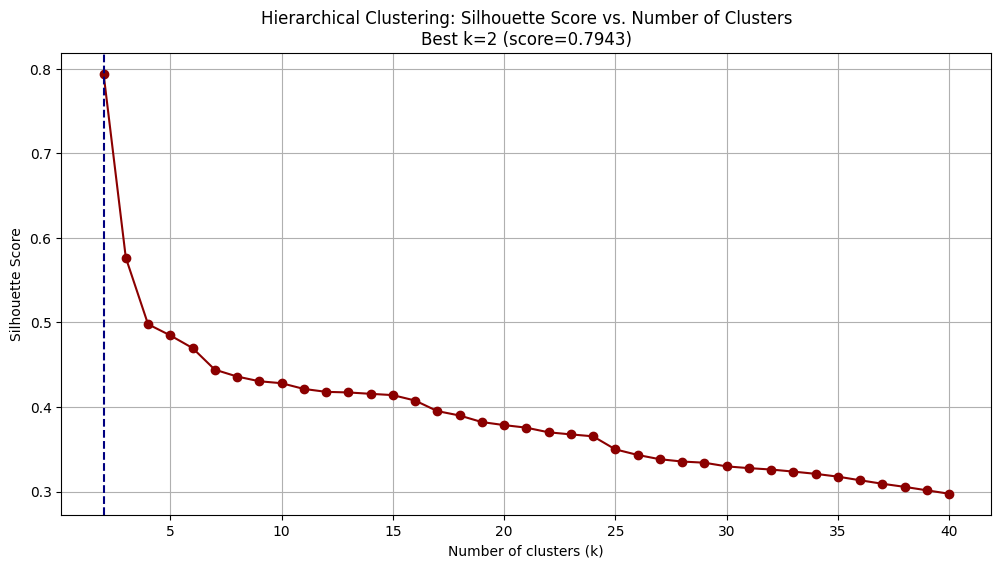

Optimal number of clusters for hierarchical clustering: 2


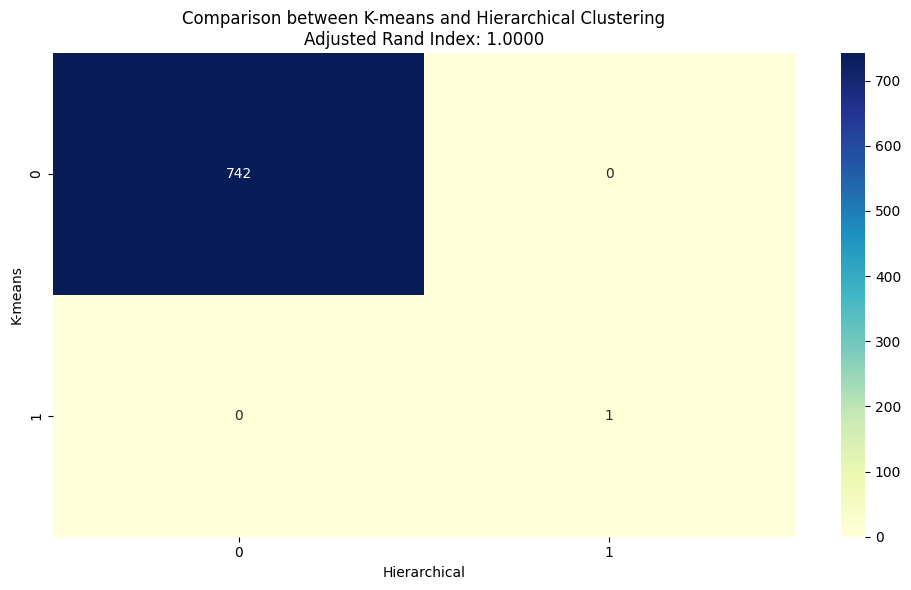

Adjusted Rand Index (similarity between K-means and Hierarchical): 1.0000
ARI of 1.0 means identical clusterings, 0.0 means random clusterings
Hierarchical clustering completed using average linkage
Hierarchical clustering results added to dataframe
  image_file  cluster  hierarchical_cluster
0  34808.jpg        0                     0
1   8917.jpg        0                     0
2  48582.jpg        0                     0
3  45027.jpg        0                     0
4  24867.jpg        0                     0
Updated clustering results saved


In [ ]:


def perform_hierarchical_clustering(feature_vectors, max_clusters=40, compare_with_kmeans=True, kmeans_labels=None):
    """
    Perform hierarchical clustering with automatic selection of optimal number of clusters
    
    Parameters:
    -----------
    feature_vectors : numpy.ndarray
        Feature vectors to cluster
    max_clusters : int
        Maximum number of clusters to consider
    compare_with_kmeans : bool
        Whether to compare results with K-means clustering
    kmeans_labels : numpy.ndarray
        K-means clustering labels for comparison
    
    Returns:
    --------
    tuple
        (optimal_k, cluster_labels)
    """
    if len(feature_vectors) < 2:
        print("Not enough samples for hierarchical clustering analysis")
        return None, None
    
    print("Finding optimal number of clusters for hierarchical clustering...")
    
    # Ensure max_clusters doesn't exceed number of samples
    max_clusters = min(max_clusters, len(feature_vectors) - 1)
    
    # Try different numbers of clusters for hierarchical clustering
    hierarchical_silhouette_scores = []
    h_k_values = range(2, max_clusters + 1)
    
    # Try different linkage methods and distance metrics
    # 'average' often works better for features with different scales
    # 'ward' works well when clusters are expected to be roughly equal size
    # 'complete' is good for finding compact, equal-diameter clusters
    linkage_method = 'average'
    
    # 'cosine' is better for high-dimensional feature vectors
    # 'euclidean' is good when features are on similar scales
    distance_metric = 'euclidean'
    
    for k in tqdm(h_k_values, desc="Evaluating hierarchical clusters"):
        try:
            # Perform hierarchical clustering
            hierarchical = AgglomerativeClustering(
                n_clusters=k, 
                linkage=linkage_method,
                distance_threshold=None,  # Required when n_clusters is specified
                compute_distances=True  # For visualization later
            )
            h_labels = hierarchical.fit_predict(feature_vectors)
            
            # Calculate silhouette score
            score = silhouette_score(feature_vectors, h_labels)
            hierarchical_silhouette_scores.append(score)
            print(f"Hierarchical k={k}, silhouette score={score:.4f}")
        except Exception as e:
            print(f"Error evaluating k={k}: {e}")
            hierarchical_silhouette_scores.append(-1)  # Use -1 to indicate error
    
    # Find k with the highest silhouette score
    valid_indices = [i for i, score in enumerate(hierarchical_silhouette_scores) if score >= 0]
    if valid_indices:
        best_idx = valid_indices[np.argmax([hierarchical_silhouette_scores[i] for i in valid_indices])]
        h_optimal_k = h_k_values[best_idx]
        best_score = hierarchical_silhouette_scores[best_idx]
    else:
        print("No valid silhouette scores found, defaulting to k=2")
        h_optimal_k = 2
        best_score = None
    
    # Plot silhouette scores
    plt.figure(figsize=(12, 6))
    
    # Filter out error values (-1) for plotting
    plot_x = [h_k_values[i] for i in valid_indices]
    plot_y = [hierarchical_silhouette_scores[i] for i in valid_indices]
    
    plt.plot(plot_x, plot_y, 'o-', color='darkred')
    plt.axvline(x=h_optimal_k, color='navy', linestyle='--')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    
    # Fix the format specifier error by moving the conditional out of the format specifier
    score_text = f"{best_score:.4f}" if best_score is not None else "N/A"
    plt.title(f'Hierarchical Clustering: Silhouette Score vs. Number of Clusters\nBest k={h_optimal_k} (score={score_text})')
    
    plt.grid(True)
    plt.show()
    
    print(f"Optimal number of clusters for hierarchical clustering: {h_optimal_k}")
    
    # Perform hierarchical clustering with optimal k and improved parameters
    hierarchical = AgglomerativeClustering(
        n_clusters=h_optimal_k, 
        linkage=linkage_method,
        distance_threshold=None,
        compute_distances=True
    )
    hierarchical_labels = hierarchical.fit_predict(feature_vectors)
    
    # Visualize the dendrogram if the dataset is not too large
    if len(feature_vectors) <= 100:
        plt.figure(figsize=(14, 8))
        visualize_dendrogram(feature_vectors, linkage_method, max_d=0.5)
        plt.title(f"Hierarchical Clustering Dendrogram ({linkage_method} linkage)")
        plt.xlabel("Sample index")
        plt.ylabel("Distance")
        plt.show()
    
    # Compare with K-means if requested
    if compare_with_kmeans and kmeans_labels is not None:
        plt.figure(figsize=(10, 6))
        
        # Adjusted Rand Index (ARI)
        ari = adjusted_rand_score(kmeans_labels, hierarchical_labels)
        
        # Create a confusion matrix between the two clusterings
        contingency_matrix = pd.crosstab(
            kmeans_labels, 
            hierarchical_labels, 
            rownames=['K-means'], 
            colnames=['Hierarchical']
        )
        
        # Plot the confusion matrix as a heatmap
        sns.heatmap(contingency_matrix, annot=True, cmap="YlGnBu", fmt='d')
        plt.title(f'Comparison between K-means and Hierarchical Clustering\nAdjusted Rand Index: {ari:.4f}')
        plt.tight_layout()
        plt.show()
        
        print(f"Adjusted Rand Index (similarity between K-means and Hierarchical): {ari:.4f}")
        print("ARI of 1.0 means identical clusterings, 0.0 means random clusterings")
    
    print(f"Hierarchical clustering completed using {linkage_method} linkage")
    return h_optimal_k, hierarchical_labels

def visualize_dendrogram(feature_vectors, method='ward', max_d=None, truncate_mode='level', p=3):
    """Visualize the dendrogram for hierarchical clustering"""
    # Compute the linkage matrix for the dendrogram
    Z = linkage(feature_vectors, method=method)
    
    # Calculate full dendrogram
    plt.figure(figsize=(15, 10))
    dendrogram(
        Z,
        truncate_mode=truncate_mode,
        p=p,  # Show only the last p merged clusters
        leaf_font_size=8,
        color_threshold=max_d,
        show_leaf_counts=True,
        above_threshold_color='grey'
    )
    if max_d:
        plt.axhline(y=max_d, c='k', ls='--', lw=1)
    return Z

# Run the hierarchical clustering if feature vectors are available
if 'feature_vectors_pca' in locals() and feature_vectors_pca is not None:
    # Import necessary libraries
    from scipy.cluster.hierarchy import dendrogram, linkage
    from sklearn.metrics import adjusted_rand_score
    import seaborn as sns
    
    # Get K-means labels if available
    kmeans_labels = clustering_results_df['cluster'].values if 'clustering_results_df' in locals() else None
    
    # Set max clusters to consider
    max_clusters = min(40, len(feature_vectors_pca) - 1)
    
    # Perform hierarchical clustering
    h_optimal_k, hierarchical_labels = perform_hierarchical_clustering(
        feature_vectors_pca,
        max_clusters=max_clusters,
        compare_with_kmeans=(kmeans_labels is not None),
        kmeans_labels=kmeans_labels
    )
    
    # Add hierarchical clustering results to the dataframe if both are available
    if hierarchical_labels is not None and 'clustering_results_df' in locals():
        clustering_results_df['hierarchical_cluster'] = hierarchical_labels
        print("Hierarchical clustering results added to dataframe")
        print(clustering_results_df.head())
        
        # Save updated results
        clustering_results_df.to_csv('accessory_clusters_with_hierarchical.csv', index=False)
        print("Updated clustering results saved")
else:
    print("Feature vectors not available for hierarchical clustering")

# Enhanced visualization of clustering results with interactive exploration options


Visualizing K-means clustering results with optimal k...


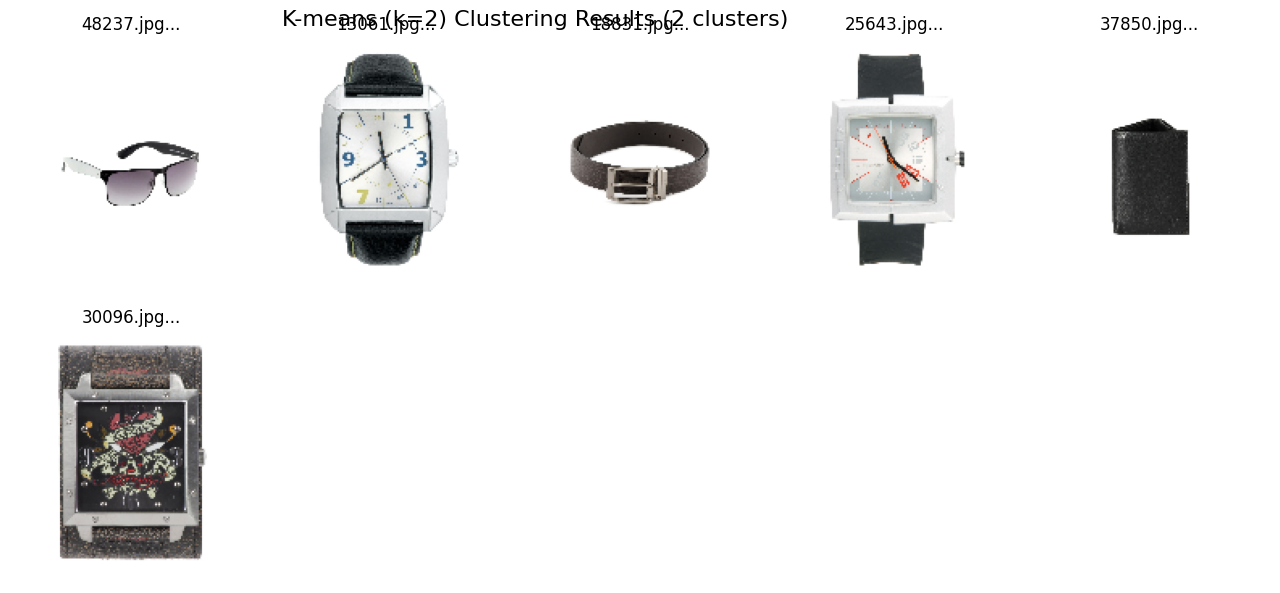


Analyzing K-means cluster characteristics...


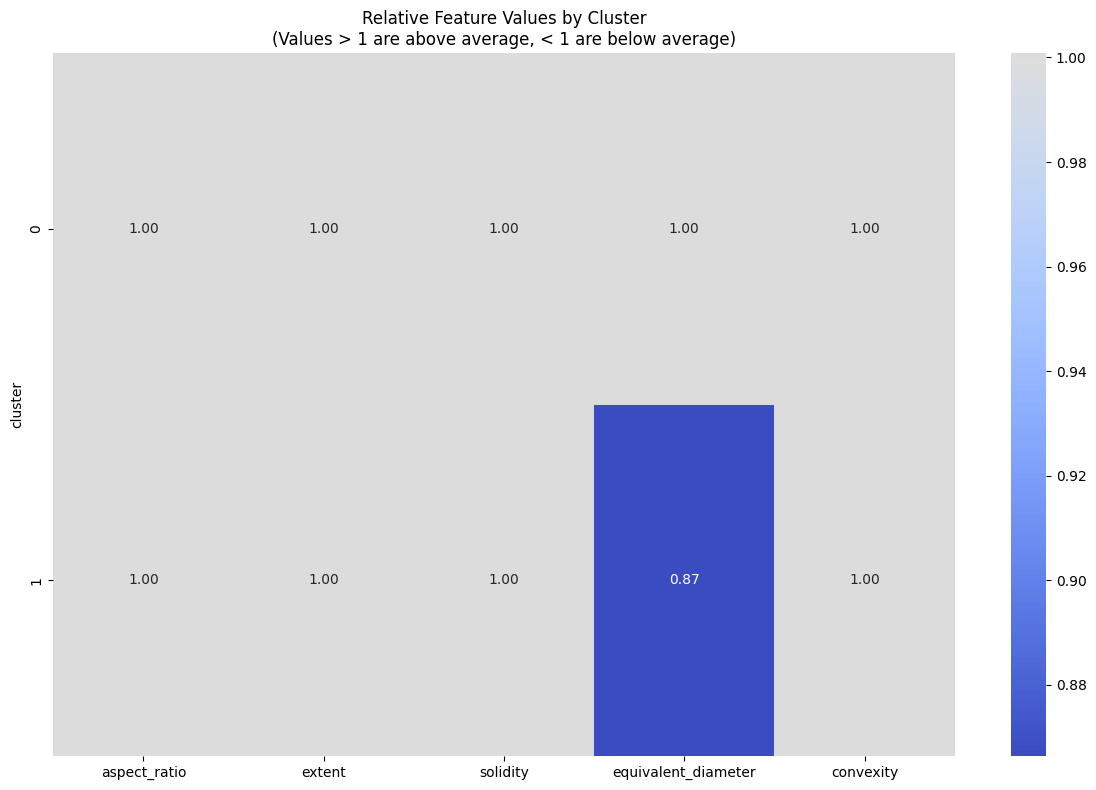


Distinctive Features by Cluster:

Cluster 0:
  Top distinctive features (higher than average):
  Bottom distinctive features (lower than average):

Cluster 1:
  Top distinctive features (higher than average):
  Bottom distinctive features (lower than average):
    - equivalent_diameter: 0.87x average

Visualizing hierarchical clustering results with optimal k...


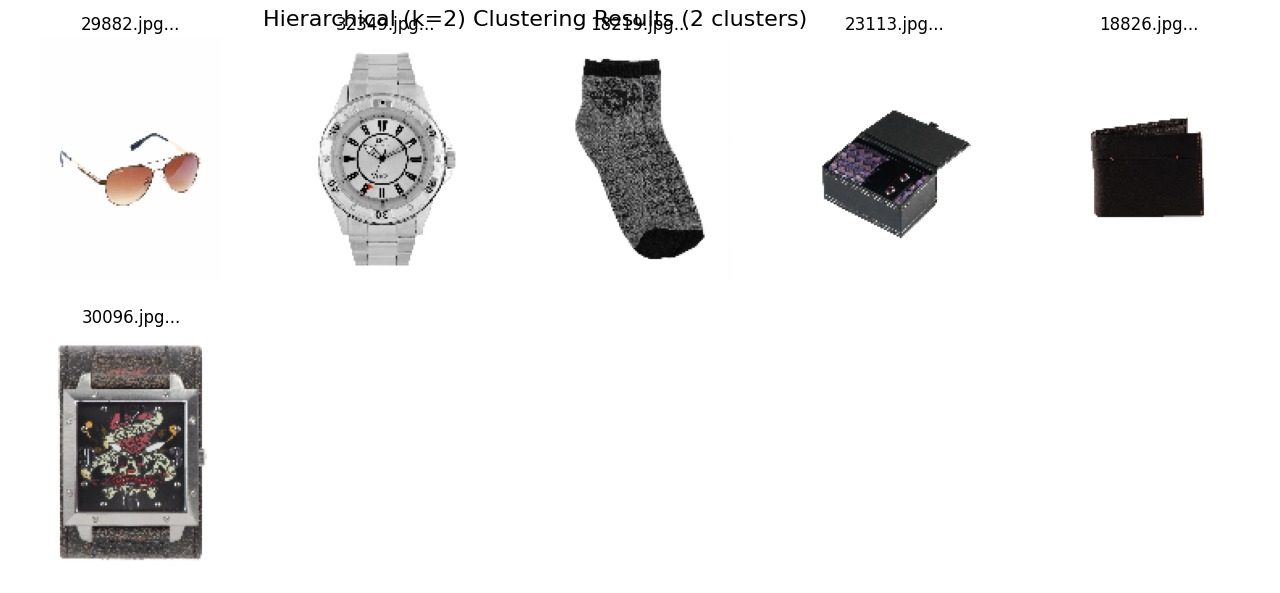


Analyzing hierarchical cluster characteristics...


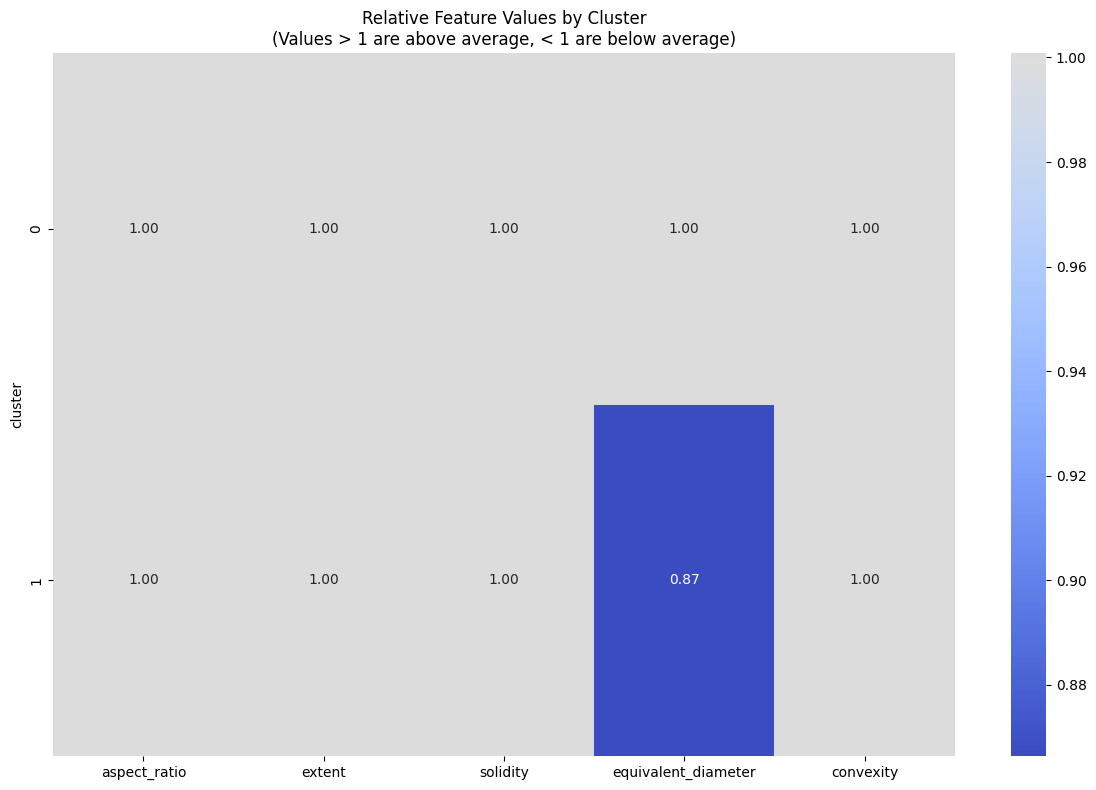


Distinctive Features by Cluster:

Cluster 0:
  Top distinctive features (higher than average):
  Bottom distinctive features (lower than average):

Cluster 1:
  Top distinctive features (higher than average):
  Bottom distinctive features (lower than average):
    - equivalent_diameter: 0.87x average

Exploring additional clustering options...
K-means (k=5) Silhouette Score: 0.0298

K-means (k=5) Cluster Distribution:
Cluster 0: 2 items (0.3%)
Cluster 1: 394 items (53.0%)
Cluster 2: 30 items (4.0%)
Cluster 3: 316 items (42.5%)
Cluster 4: 1 items (0.1%)


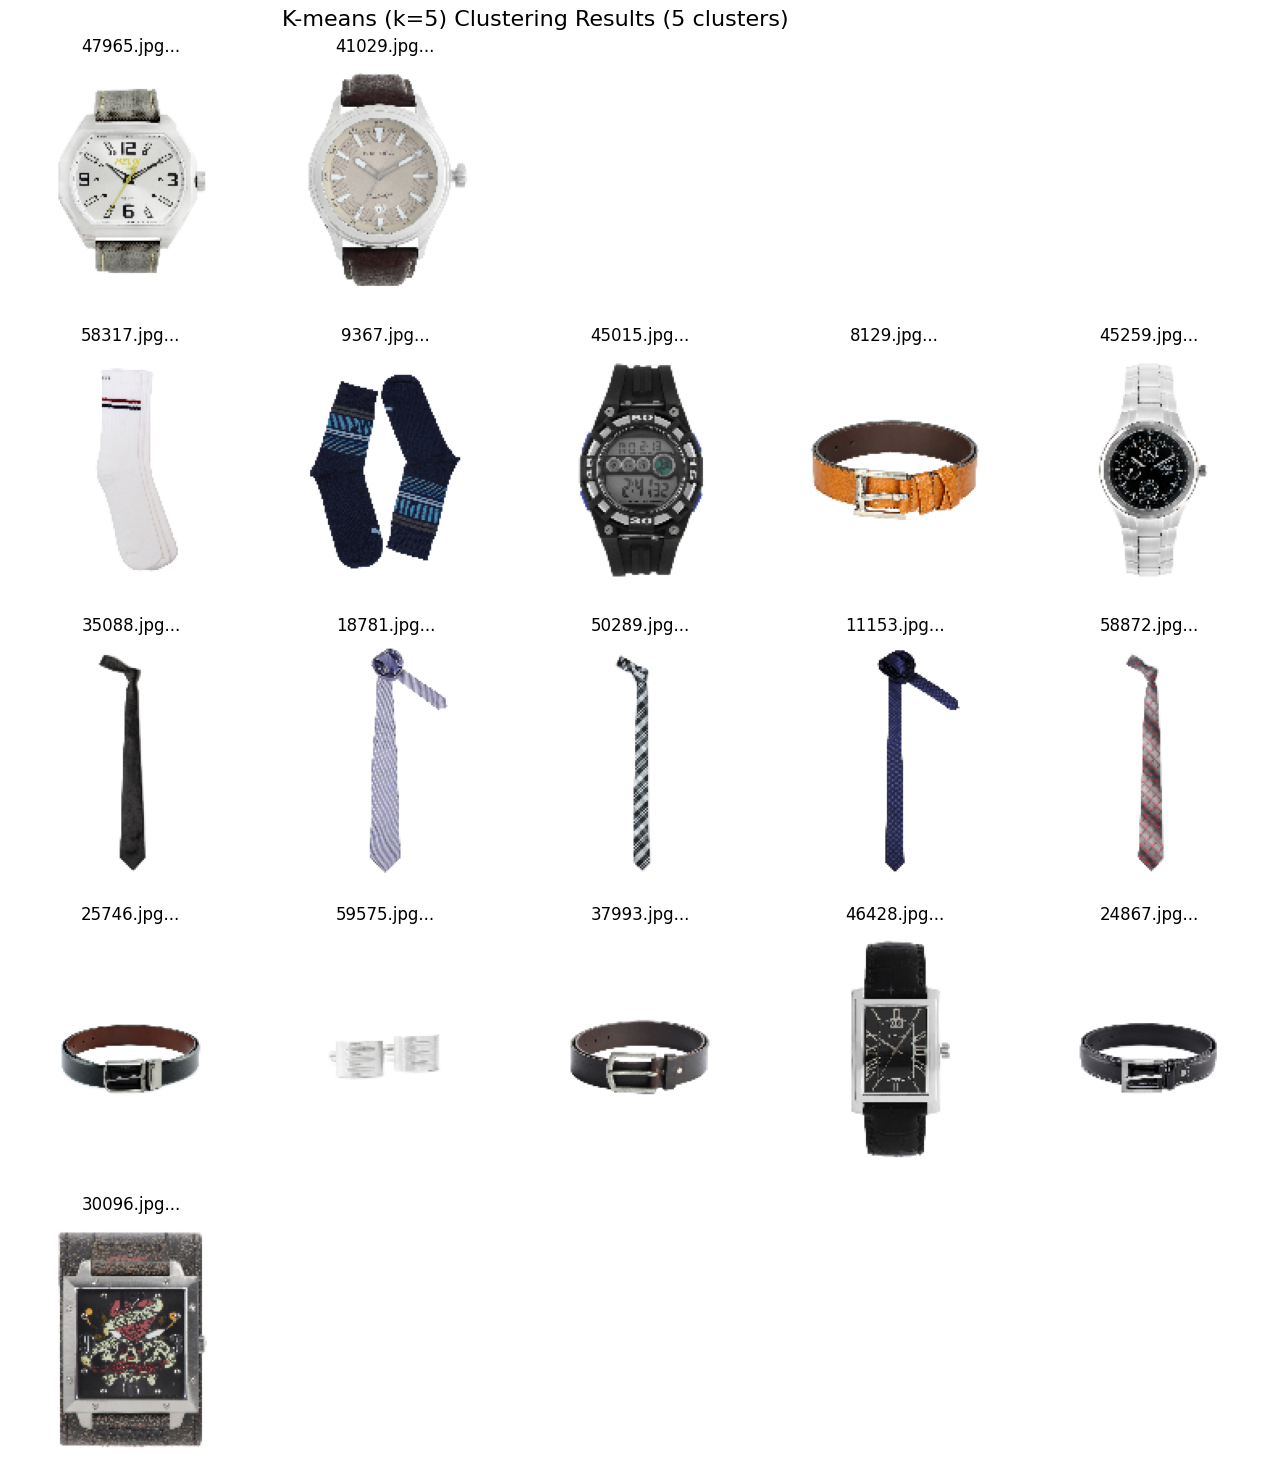

Hierarchical (k=3) Silhouette Score: 0.0116

Hierarchical (k=3) Cluster Distribution:
Cluster 0: 468 items (63.0%)
Cluster 1: 1 items (0.1%)
Cluster 2: 274 items (36.9%)


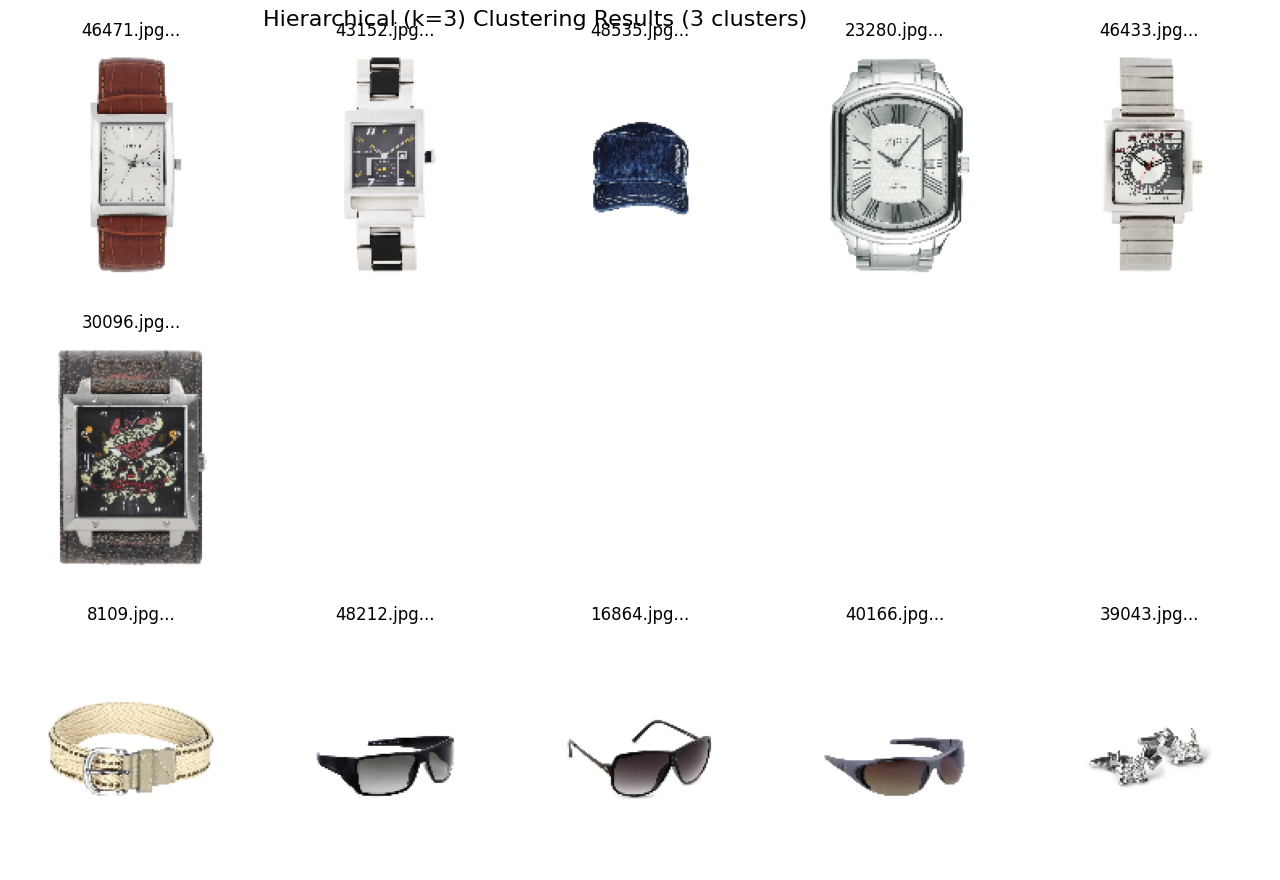


Clustering exploration completed


In [ ]:


def visualize_clusters(image_files, cluster_labels, dataset_path, num_clusters, method='K-means', samples_per_cluster=5):
    """
    Visualize clustering results with sample images from each cluster
    
    Parameters:"
    -----------
    image_files : list
        List of image filenames
    cluster_labels : array
        Cluster assignments for each image
    dataset_path : str
        Path to the image dataset
    num_clusters : int
        Number of clusters
    method : str
        Name of the clustering method for display
    samples_per_cluster : int
        Number of sample images to show per cluster
    """
    # Create a figure with subplots for each cluster
    fig, axes = plt.subplots(num_clusters, samples_per_cluster, figsize=(15, 3*num_clusters))
    
    # If only one cluster, make axes 2D
    if num_clusters == 1:
        axes = np.array([axes])
    
    # Count images per cluster for displaying statistics
    cluster_counts = {}
    for label in cluster_labels:
        if label in cluster_counts:
            cluster_counts[label] += 1
        else:
            cluster_counts[label] = 1
    
    # For each cluster, display sample images
    for cluster in range(num_clusters):
        # Get all images in this cluster
        cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster]
        
        # Check if cluster exists
        if cluster not in cluster_counts:
            # Turn off all subplots for empty clusters
            for i in range(samples_per_cluster):
                axes[cluster, i].axis('off')
            continue
            
        # Get percentage of dataset in this cluster
        cluster_size = cluster_counts.get(cluster, 0)
        percentage = (cluster_size / len(image_files)) * 100
        
        # Select up to samples_per_cluster random images
        sample_size = min(samples_per_cluster, len(cluster_indices))
        if sample_size > 0:
            # Use random sampling without replacement
            sample_indices = np.random.choice(cluster_indices, size=sample_size, replace=False)
            
            # Display each sample
            for i, idx in enumerate(sample_indices):
                img_path = os.path.join(dataset_path, image_files[idx])
                img = cv2.imread(img_path)
                
                if img is None:
                    # Handle missing or corrupted images
                    axes[cluster, i].text(0.5, 0.5, "Image not found", 
                                         ha='center', va='center',
                                         transform=axes[cluster, i].transAxes)
                    axes[cluster, i].set_title(f"Cluster {cluster}")
                    axes[cluster, i].axis('off')
                    continue
                    
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Resize for display while maintaining aspect ratio
                h, w = img.shape[:2]
                aspect = w / h
                if aspect > 1:
                    # Wider than tall
                    new_w, new_h = 150, int(150 / aspect)
                else:
                    # Taller than wide
                    new_w, new_h = int(150 * aspect), 150
                
                img_resized = cv2.resize(img, (new_w, new_h))
                
                # Create background for consistent display
                display_img = np.ones((150, 150, 3), dtype=np.uint8) * 255
                y_offset = (150 - new_h) // 2
                x_offset = (150 - new_w) // 2
                display_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = img_resized
                
                # Display image
                axes[cluster, i].imshow(display_img)
                axes[cluster, i].set_title(f"{os.path.basename(image_files[idx])[:10]}...")
                axes[cluster, i].axis('off')
            
            # Add cluster information to first image
            axes[cluster, 0].set_ylabel(f"Cluster {cluster}\n{cluster_size} items\n({percentage:.1f}%)", 
                                       fontsize=10, rotation=0, labelpad=40, va='center', ha='right')
            
            # Turn off unused subplots
            for i in range(sample_size, samples_per_cluster):
                axes[cluster, i].axis('off')
        else:
            # Turn off all subplots for empty clusters
            for i in range(samples_per_cluster):
                axes[cluster, i].axis('off')
    
    plt.suptitle(f'{method} Clustering Results ({num_clusters} clusters)', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, left=0.15)  # Make room for the cluster labels
    plt.show()

def explore_clustering(k_value, feature_vectors, image_files, dataset_path, algorithm='kmeans', display=True):
    """
    Perform clustering with a specific k value and visualize results
    
    Parameters:
    -----------
    k_value : int
        Number of clusters
    feature_vectors : numpy.ndarray
        Feature vectors to cluster
    image_files : list
        List of image filenames
    dataset_path : str
        Path to the image dataset
    algorithm : str
        'kmeans' or 'hierarchical'
    display : bool
        Whether to display visualization
    
    Returns:
    --------
    numpy.ndarray
        Cluster labels
    """
    if algorithm.lower() == 'kmeans':
        # Perform K-means clustering with specified k
        kmeans_custom = KMeans(n_clusters=k_value, random_state=42, n_init=10)
        labels = kmeans_custom.fit_predict(feature_vectors)
        method_name = f'K-means (k={k_value})'
    else:
        # Perform hierarchical clustering with specified k
        hierarchical_custom = AgglomerativeClustering(n_clusters=k_value)
        labels = hierarchical_custom.fit_predict(feature_vectors)
        method_name = f'Hierarchical (k={k_value})'
    
    # Calculate silhouette score to evaluate cluster quality
    try:
        sil_score = silhouette_score(feature_vectors, labels)
        print(f"{method_name} Silhouette Score: {sil_score:.4f}")
    except:
        print(f"Could not calculate silhouette score for {method_name}")
    
    # Display statistics about cluster sizes
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(f"\n{method_name} Cluster Distribution:")
    for label, count in zip(unique_labels, counts):
        percentage = (count / len(labels)) * 100
        print(f"Cluster {label}: {count} items ({percentage:.1f}%)")
    
    # Visualize the clusters if requested
    if display:
        visualize_clusters(image_files, labels, dataset_path, k_value, method_name)
    
    return labels

def analyze_cluster_features(image_files, labels, feature_data, num_clusters, top_n=5):
    """
    Analyze key features that define each cluster
    
    Parameters:
    -----------
    image_files : list
        List of image filenames
    labels : array
        Cluster assignments
    feature_data : dict
        Dictionary containing feature data for each image
    num_clusters : int
        Number of clusters
    top_n : int
        Number of top features to display
    """
    if feature_data is None:
        print("No feature data available for analysis")
        return
    
    # Create a dataframe with cluster labels
    cluster_df = pd.DataFrame({
        'image_file': image_files,
        'cluster': labels
    })
    
    # Extract shape features
    shape_data = []
    for idx, row in cluster_df.iterrows():
        img_file = row['image_file']
        cluster = row['cluster']
        
        if img_file in feature_data and 'shape_features' in feature_data[img_file]:
            shape_dict = feature_data[img_file]['shape_features'].copy()
            # Ensure we only have numeric features
            shape_values = {}
            for key, value in shape_dict.items():
                try:
                    shape_values[key] = float(value)
                except (ValueError, TypeError):
                    continue
                    
            shape_values['cluster'] = int(cluster)
            shape_values['image_file'] = img_file
            shape_data.append(shape_values)
    
    if not shape_data:
        print("No valid shape feature data available")
        return
        
    # Create a dataframe with shape features
    shape_df = pd.DataFrame(shape_data)
    
    # Calculate mean features for each cluster
    feature_cols = [col for col in shape_df.columns if col not in ['cluster', 'image_file']]
    
    if not feature_cols:
        print("No valid feature columns found")
        return
        
    # Calculate cluster means
    try:
        cluster_means = shape_df.groupby('cluster')[feature_cols].mean()
        
        # Calculate overall mean for comparison
        overall_mean = shape_df[feature_cols].mean()
        
        # Create a heatmap of normalized feature values by cluster
        plt.figure(figsize=(12, 8))
        
        # Calculate relative values (how much above/below average)
        relative_means = cluster_means.copy()
        for col in feature_cols:
            relative_means[col] = cluster_means[col] / overall_mean[col]
        
        # Create heatmap
        sns.heatmap(relative_means, annot=True, cmap="coolwarm", center=1.0, fmt=".2f")
        plt.title('Relative Feature Values by Cluster\n(Values > 1 are above average, < 1 are below average)')
        plt.tight_layout()
        plt.show()
        
        # Identify distinctive features for each cluster
        print("\nDistinctive Features by Cluster:")
        for cluster in range(num_clusters):
            if cluster in cluster_means.index:
                print(f"\nCluster {cluster}:")
                # Get relative feature values
                relative_features = relative_means.loc[cluster]
                
                # Find top and bottom features
                top_features = relative_features.nlargest(min(top_n, len(feature_cols)))
                bottom_features = relative_features.nsmallest(min(top_n, len(feature_cols)))
                
                print("  Top distinctive features (higher than average):")
                for feature, value in top_features.items():
                    if value > 1.1:  # Only show features significantly above average
                        print(f"    - {feature}: {value:.2f}x average")
                
                print("  Bottom distinctive features (lower than average):")
                for feature, value in bottom_features.items():
                    if value < 0.9:  # Only show features significantly below average
                        print(f"    - {feature}: {value:.2f}x average")
    
    except Exception as e:
        print(f"Error analyzing cluster features: {e}")

# Visualize clustering results if data is available
if ('feature_vectors_pca' in locals() and feature_vectors_pca is not None and 
    'image_files' in locals() and 'dataset_path' in locals()):
    
    # Import required libraries if not already imported
    import seaborn as sns
    from sklearn.metrics import silhouette_score
    
    # Visualize K-means clustering results if available
    if 'cluster_labels' in locals() and 'optimal_k' in locals():
        print("\nVisualizing K-means clustering results with optimal k...")
        visualize_clusters(image_files, cluster_labels, dataset_path, optimal_k, f'K-means (k={optimal_k})')
        
        # Analyze distinctive features for K-means clusters
        print("\nAnalyzing K-means cluster characteristics...")
        analyze_cluster_features(image_files, cluster_labels, feature_data, optimal_k)
    
    # Visualize hierarchical clustering results if available
    if 'hierarchical_labels' in locals() and 'h_optimal_k' in locals():
        print("\nVisualizing hierarchical clustering results with optimal k...")
        visualize_clusters(image_files, hierarchical_labels, dataset_path, h_optimal_k, f'Hierarchical (k={h_optimal_k})')
        
        # Analyze distinctive features for hierarchical clusters
        print("\nAnalyzing hierarchical cluster characteristics...")
        analyze_cluster_features(image_files, hierarchical_labels, feature_data, h_optimal_k)
    
    # Explore custom cluster counts
    print("\nExploring additional clustering options...")
    
    # Try K-means with a different number of clusters (5)
    k_means_5_labels = explore_clustering(5, feature_vectors_pca, image_files, dataset_path, 'kmeans')
    
    # Try hierarchical with a different number of clusters (4)
    hier_4_labels = explore_clustering(3, feature_vectors_pca, image_files, dataset_path, 'hierarchical')
    
    print("\nClustering exploration completed")
else:
    print("Required data for visualization not available")

# Runtime analysis


In [ ]:

# Function to measure time
def measure_runtime(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    runtime = end_time - start_time
    return runtime  # Just return the runtime, not a tuple with the result

# Measure feature extraction time for a sample image
if len(image_files) > 0:
    sample_img = image_files[0]
    img_path = os.path.join(dataset_path, sample_img)
    
    # Measure SIFT feature extraction time
    sift_time = measure_runtime(preprocess_and_extract_features, img_path)
    
    # Measure texture feature extraction time
    texture_time = measure_runtime(extract_texture_features, img_path)
    
    # Measure color feature extraction time (if you added this feature)
    color_time = measure_runtime(extract_color_features, processed_img)
    
    # Print results
    print("Runtime Analysis (per image):")
    print(f"SIFT Feature Extraction: {sift_time:.4f} seconds")
    print(f"Texture Feature Extraction: {texture_time:.4f} seconds")
    print(f"Color Feature Extraction: {color_time:.4f} seconds")
    print(f"Total Feature Extraction: {sift_time + texture_time + color_time:.4f} seconds")

Runtime Analysis (per image):
SIFT Feature Extraction: 0.3316 seconds
Texture Feature Extraction: 0.0302 seconds
Color Feature Extraction: 1.9944 seconds
Total Feature Extraction: 2.3562 seconds


# Visualize feature distributions and similarities

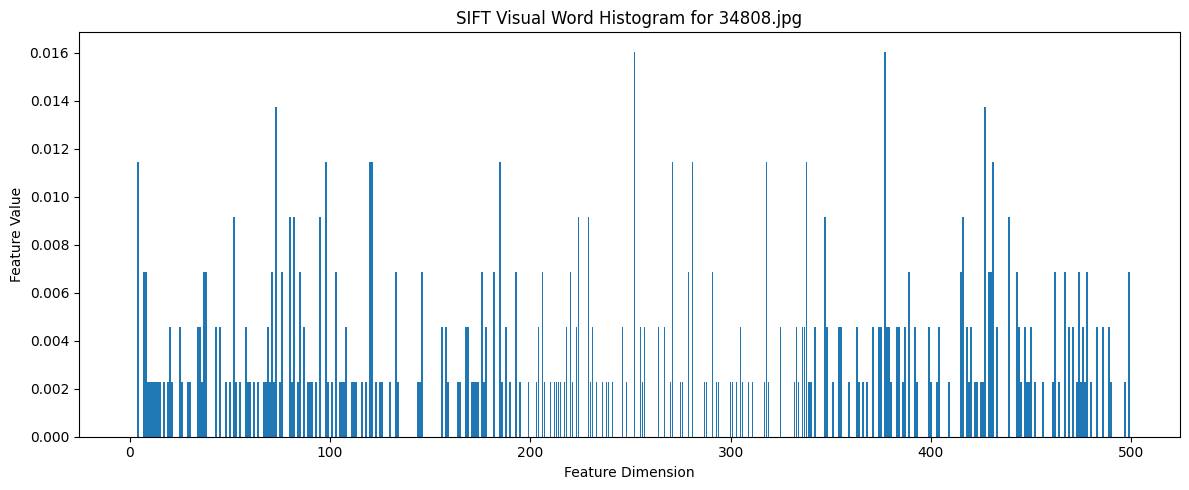

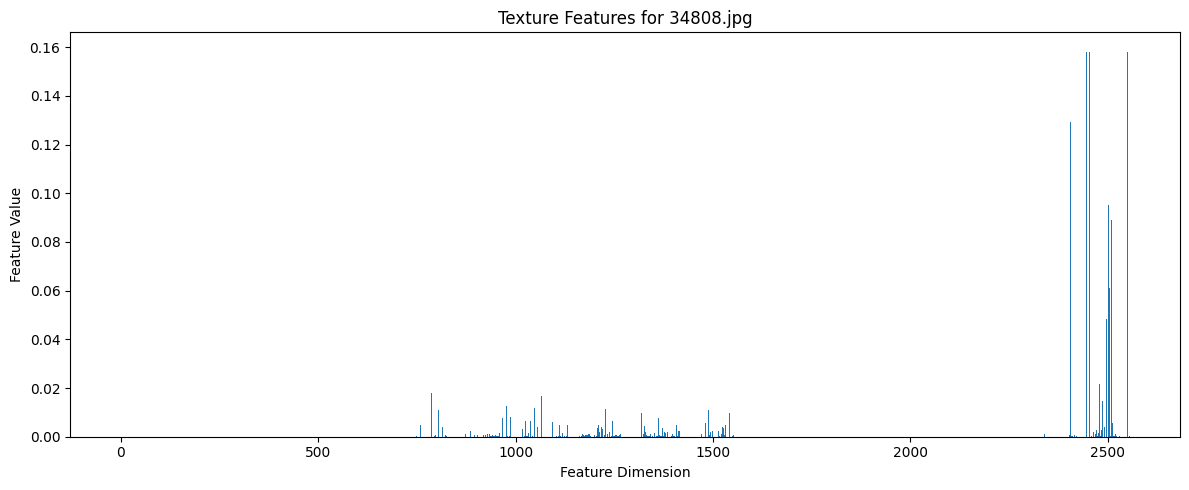

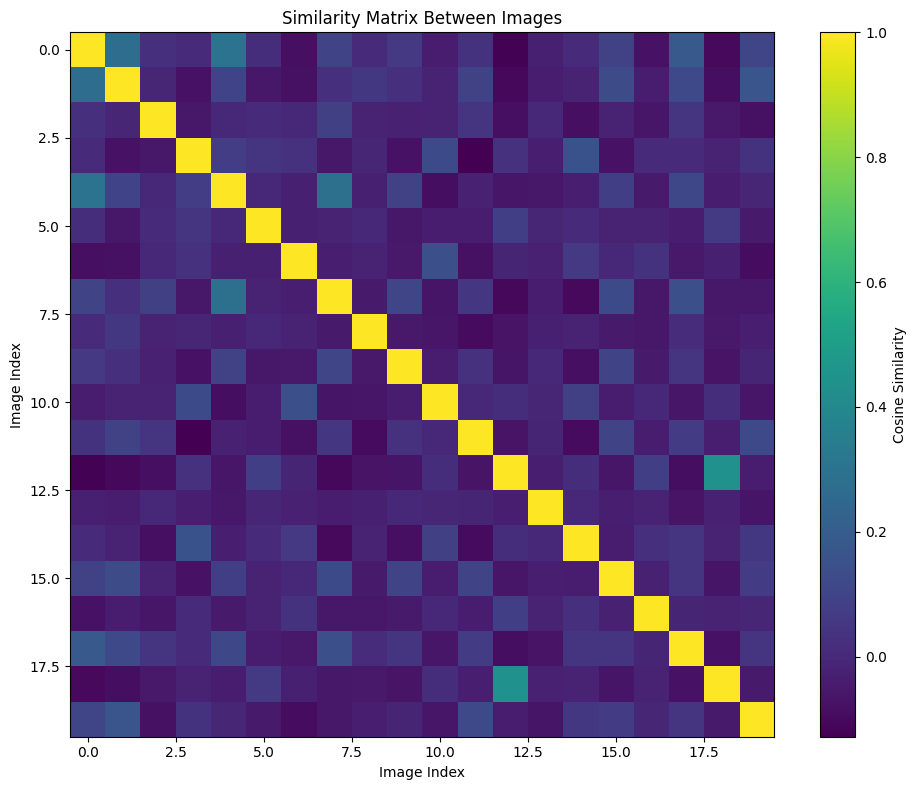

In [ ]:

# Function to visualize feature histograms
def plot_feature_histogram(feature_vector, title):
    plt.figure(figsize=(12, 5))
    plt.bar(range(len(feature_vector)), feature_vector)
    plt.title(title)
    plt.xlabel('Feature Dimension')
    plt.ylabel('Feature Value')
    plt.tight_layout()
    plt.show()
# Select a sample image for visualization
if len(image_files) > 0:
    sample_image = image_files[0]

    # Plot feature histogram for the sample image
    feature_vector = image_features[sample_image]

    # Separate SIFT histogram and texture features
    sift_histogram = feature_vector[:num_words]
    texture_features = feature_vector[num_words:] if len(feature_vector) > num_words else None

    # Visualize
    plot_feature_histogram(sift_histogram, f"SIFT Visual Word Histogram for {sample_image}")

    if texture_features is not None:
        plot_feature_histogram(texture_features, f"Texture Features for {sample_image}")

    # Create a similarity matrix for the first 20 images
    from sklearn.metrics.pairwise import cosine_similarity

    n_samples = min(20, len(feature_vectors_scaled))
    similarity_matrix = cosine_similarity(feature_vectors_scaled[:n_samples])

    plt.figure(figsize=(10, 8))
    plt.imshow(similarity_matrix, cmap='viridis')
    plt.colorbar(label='Cosine Similarity')
    plt.title('Similarity Matrix Between Images')
    plt.xlabel('Image Index')
    plt.ylabel('Image Index')
    plt.tight_layout()
    plt.show()